# Forecasting Customer Demand in Python

How to predict the number of dinner customers at a busy restaurant. Extending our model to include external regressors.

## Load packages and import data

In [2]:
#Locate imported packages
import sys
sys.path

#import pandas and numpy
import pandas as pd
import numpy as np

# From matplotlib, import pyplot under the alias plt
from matplotlib import pyplot as plt

#Import library
from prophet import Prophet
from prophet.plot import plot_yearly, plot_forecast_component, add_changepoints_to_plot
from prophet.utilities import regressor_coefficients


# Reading an excel file using Python
import os

In [3]:
# Give the location of your file -
file = ('datasets/Dinner.xlsx')
 
#Load spreadsheet
data = pd.ExcelFile(file)

## Load a sheet into a DataFrame by name
df = data.parse('dinner')

#Check results
print(df.head())

        Date  Cust count dinner
0 2001-06-28                402
1 2001-06-29                573
2 2001-06-30                564
3 2001-07-01                403
4 2001-07-02                275


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1559 non-null   datetime64[ns]
 1   Cust count dinner  1559 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 24.5 KB
None


## Data Prep

In [5]:
#Rename columns
df.rename(columns = {'Date': 'ds', 'Cust count dinner': 'y'},inplace = True)

#Check results of renaming
print(df.columns)

Index(['ds', 'y'], dtype='object')


## Exploratory Data Analysis (EDA)

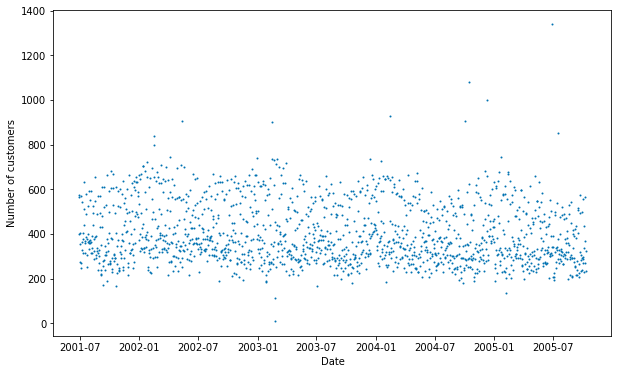

In [6]:
#Number of customers per day
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'], s=1, c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Number of customers')
plt.show()

This is count data as it represents the number of customers each day. The trend seems to be decreasing over time.

## Model Fit

In [7]:
#We need to initiate a Prophet object
m = Prophet(seasonality_mode='multiplicative')
#m = Prophet()

#Fit model
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       3755.12   0.000168107       148.589   8.454e-07       0.001      140  LS failed, Hessian reset 
      99       3755.39   0.000284232        71.546           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3755.45   6.55666e-07       77.1415      0.2635           1      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Prophet's default mode for seasonality is additive, but because we are counting number of customers per day, will change to multiplicative mode.

## How did Prophet handle the data

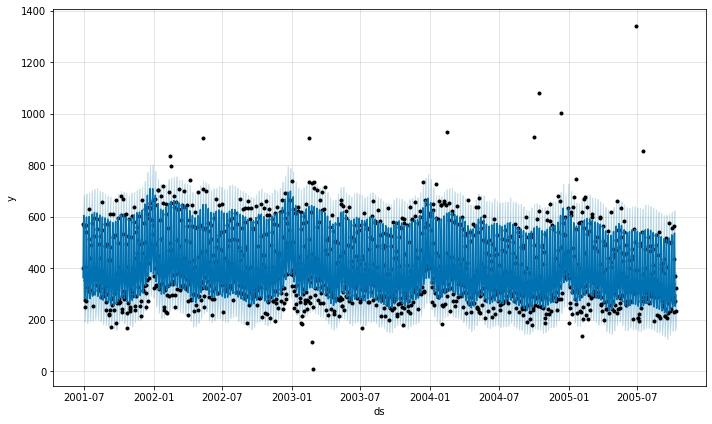

In [8]:
#Create forecast using predict function - if no future dataframe is created then the
#predict function will simply predict values on the historical data that was fit in
#the model
#We just want to see how Prophet handeled seasonality
forecast = m.predict()


fig_a_model = m.plot(forecast)
plt.show()

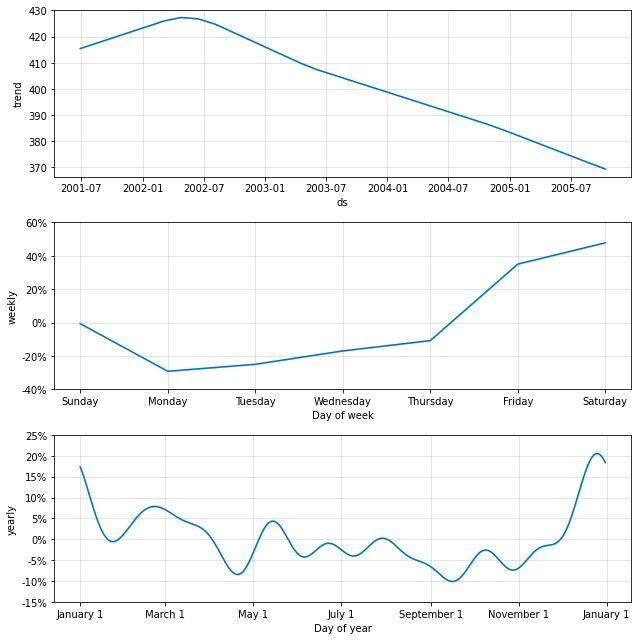

In [9]:
#Components plot
fig = m.plot_components(forecast)

There are 3 components: Trend, Weekly, and Yearly. If you have a dataset that has at least two years of data, Prophet will automatically detect and isolate yearly seasonality components. You need at least two weeks of data for weekly seasonality to be included. 

Trend shows that demand increased sharply between 2001 and June 2002, but has been decreasing linearly since then. Average customer demand by the summer of 2005 has decreased to around 370 from a peak of over an average at 420. The weekly trend shows that demand starts to increases sharply on Fridays and Saturdays.Demand is roughly 40% higher than on the weekdays.  The yearly trend is very wavy showing high peak demand in December and then a few peaks in March, May, August, October. This could indicate mean the yearly seasonality is too flexible.

Fourier series is how seasonality is controlled.

### Create holidays dataframes

In [10]:
superbowls = pd.DataFrame({
  'holiday':'superbowl',
  'ds': pd.to_datetime(['2001-01-28', '2002-02-03', '2003-01-26', '2004-02-01', '2005-02-06', '2006-02-05', '2007-02-05','2008-02-03', '2009-02-01', '2010-02-07', '2014-02-02', '2016-02-07'])#,
  #'lower_window': 0,
  #'upper_window' : 1
})

print(superbowls)

      holiday         ds
0   superbowl 2001-01-28
1   superbowl 2002-02-03
2   superbowl 2003-01-26
3   superbowl 2004-02-01
4   superbowl 2005-02-06
5   superbowl 2006-02-05
6   superbowl 2007-02-05
7   superbowl 2008-02-03
8   superbowl 2009-02-01
9   superbowl 2010-02-07
10  superbowl 2014-02-02
11  superbowl 2016-02-07


In [11]:
valentines = pd.DataFrame({
  'holiday': 'valentines_day',
  'ds': pd.to_datetime(['2001-02-14', '2002-02-14', '2003-02-14', '2004-02-14', '2005-02-14', '2006-02-14'])
})

print(valentines)

          holiday         ds
0  valentines_day 2001-02-14
1  valentines_day 2002-02-14
2  valentines_day 2003-02-14
3  valentines_day 2004-02-14
4  valentines_day 2005-02-14
5  valentines_day 2006-02-14


In [12]:
mothers = pd.DataFrame({
  'holiday': 'mothers_day',
  'ds': pd.to_datetime(['2001-05-13', '2002-05-12', '2003-05-11', '2004-05-09', '2005-05-08', '2006-05-14'])
})

print(mothers)

       holiday         ds
0  mothers_day 2001-05-13
1  mothers_day 2002-05-12
2  mothers_day 2003-05-11
3  mothers_day 2004-05-09
4  mothers_day 2005-05-08
5  mothers_day 2006-05-14


In [13]:
halloween = pd.DataFrame({
  'holiday': 'halloween',
  'ds': pd.to_datetime(['2001-10-31', '2002-10-31', '2003-10-31', '2004-10-31', '2005-10-31', '2006-10-31'])
})

print(halloween)

     holiday         ds
0  halloween 2001-10-31
1  halloween 2002-10-31
2  halloween 2003-10-31
3  halloween 2004-10-31
4  halloween 2005-10-31
5  halloween 2006-10-31


In [14]:
christmas_eve = pd.DataFrame({
  'holiday': 'christmas_eve',
  'ds': pd.to_datetime(['2001-12-24', '2002-12-24', '2003-12-24', '2004-12-24', '2005-12-24', '2006-12-24'])
})

print(christmas_eve)

         holiday         ds
0  christmas_eve 2001-12-24
1  christmas_eve 2002-12-24
2  christmas_eve 2003-12-24
3  christmas_eve 2004-12-24
4  christmas_eve 2005-12-24
5  christmas_eve 2006-12-24


In [15]:
newyears_eve = pd.DataFrame({
  'holiday': 'newyears_eve',
  'ds': pd.to_datetime(['2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31'])
})

print(newyears_eve)

        holiday         ds
0  newyears_eve 2001-12-31
1  newyears_eve 2002-12-31
2  newyears_eve 2003-12-31
3  newyears_eve 2004-12-31
4  newyears_eve 2005-12-31
5  newyears_eve 2006-12-31


## Model with yearly seasonality argument 

In [16]:
#Create holiday dataframe
holidays = pd.concat([superbowls, valentines, mothers, halloween, christmas_eve, newyears_eve])

print(holidays.tail())

        holiday         ds
1  newyears_eve 2002-12-31
2  newyears_eve 2003-12-31
3  newyears_eve 2004-12-31
4  newyears_eve 2005-12-31
5  newyears_eve 2006-12-31


In [17]:
#We need to initiate a Prophet object
m_02 = Prophet(holidays = holidays, seasonality_mode='multiplicative', yearly_seasonality = 3)

#Add country holidays
m_02.add_country_holidays(country_name='US')

#Fit model
m_02.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3932.49    0.00873812        333.55           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3938.39    0.00161737       165.572           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3943.4   0.000781068       91.7783           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3943.63   0.000118263       88.6206      0.3246           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3944.66   0.000211197       91.6321       1.846      0.5159      619   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     551     

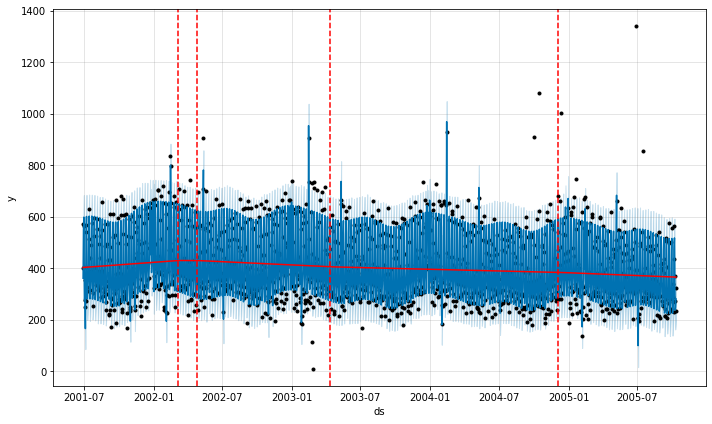

In [18]:
#Plot forecast
forecast_02 = m_02.predict()

#Plot with changepoints
#Changepoints are locations in time series data where the trend component suddenly
#Changes the slope
fig_b_model = m_02.plot(forecast_02)
add_changepoints_to_plot(fig_b_model.gca(), m_02, forecast_02)
plt.show()

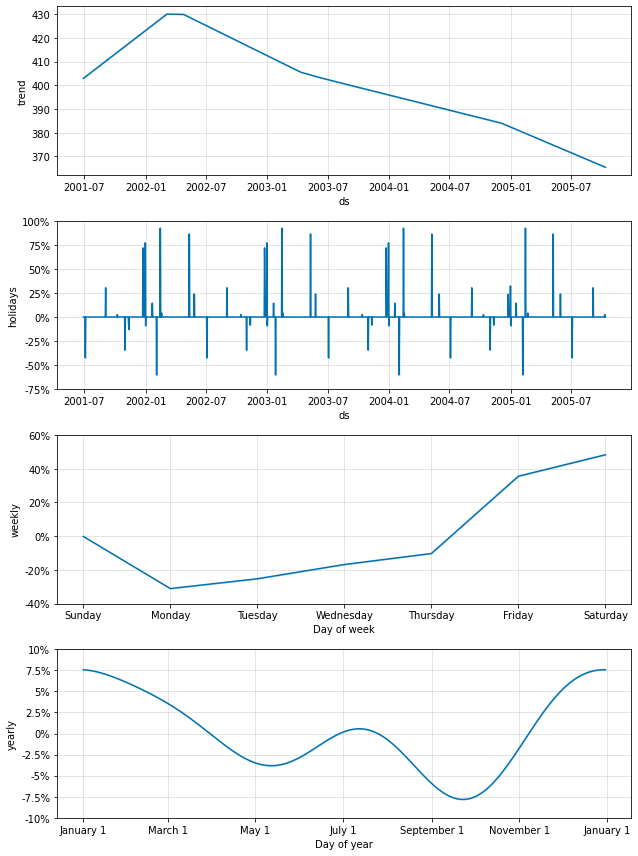

In [19]:
#Components plot
fig_02 = m_02.plot_components(forecast_02)

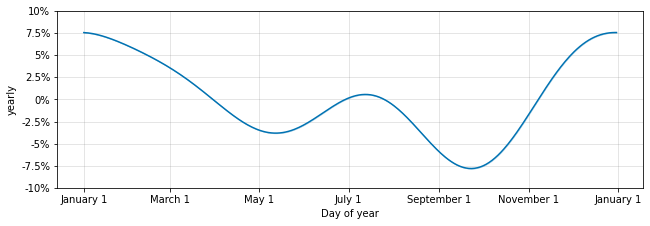

In [20]:
#Plot the yearly seasonality only - Fourier order of 4
plot_yearly(m_02, figsize=(10.5, 3.25))
plt.show()

## Create Forecast

In [21]:
#Make future dataframe 
#Period equals 365 days times 1 or 1 year
future = m_02.make_future_dataframe(periods=365 * 1)
future_forecast = m_02.predict(future)

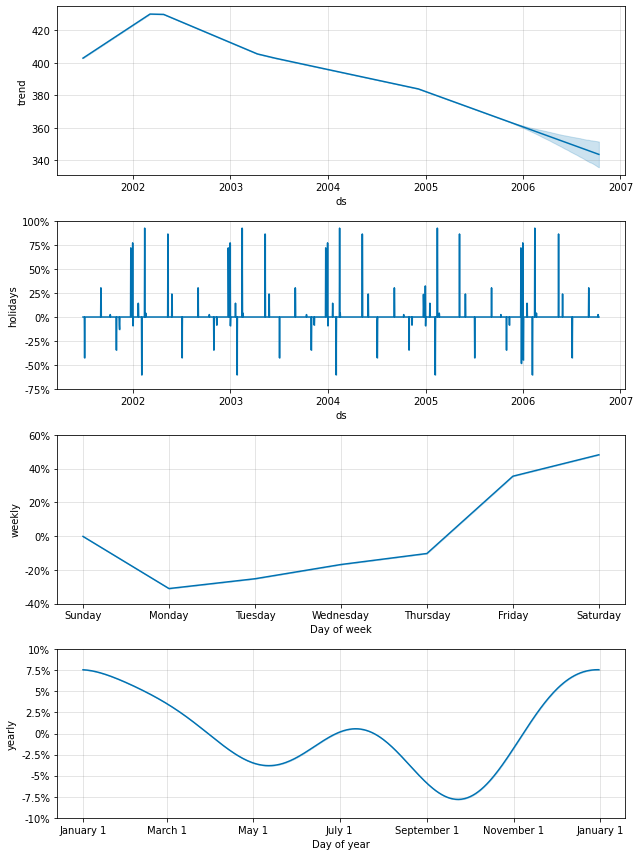

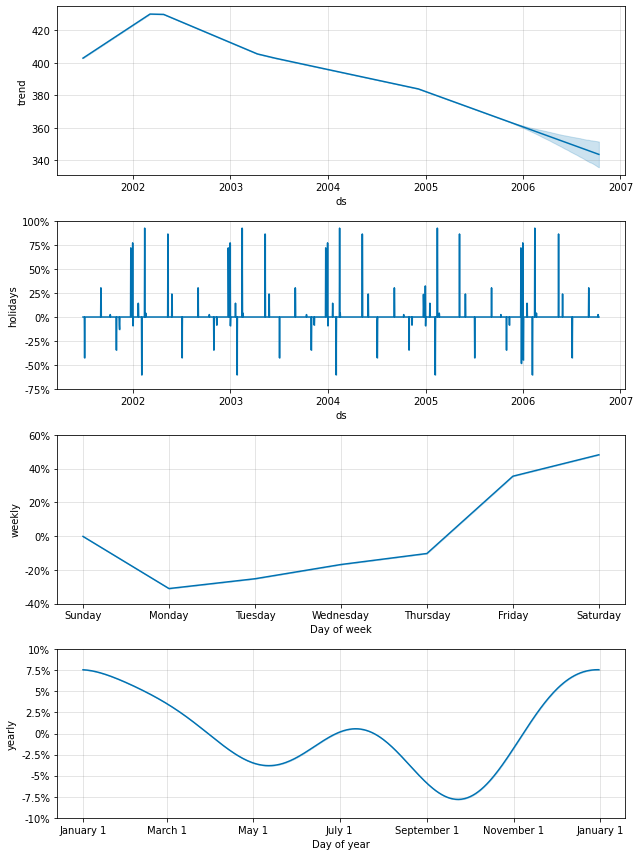

In [22]:
#Plot the components
m_02.plot_components(future_forecast)

US Holidays component shows the spikes corresponding to a holiday.

In [158]:
#Show the holidays the data was trained on
m_02.train_holiday_names

0                       superbowl
1                  valentines_day
2                     mothers_day
3                       halloween
4                   christmas_eve
5                    newyears_eve
6                  New Year's Day
7      Martin Luther King Jr. Day
8           Washington's Birthday
9                    Memorial Day
10               Independence Day
11                      Labor Day
12                   Columbus Day
13                   Veterans Day
14        Veterans Day (Observed)
15                   Thanksgiving
16                  Christmas Day
17      New Year's Day (Observed)
18    Independence Day (Observed)
19       Christmas Day (Observed)
dtype: object

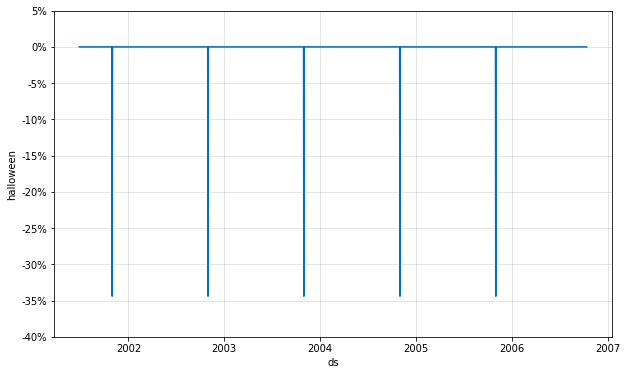

In [159]:
#Can plot individual holidays using the plot_forecast_component
plot_forecast_component(m_02, future_forecast, 'halloween')
#Halloween shows an average decrease of 35% of customer demand

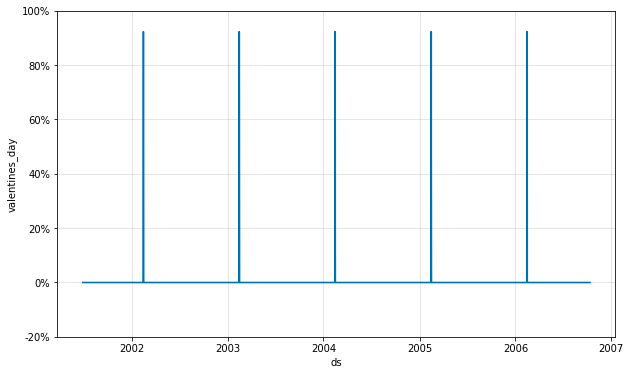

In [24]:
plot_forecast_component(m_02, future_forecast, 'valentines_day')
#A huge increase of customers around 90% on average on Valentines Day

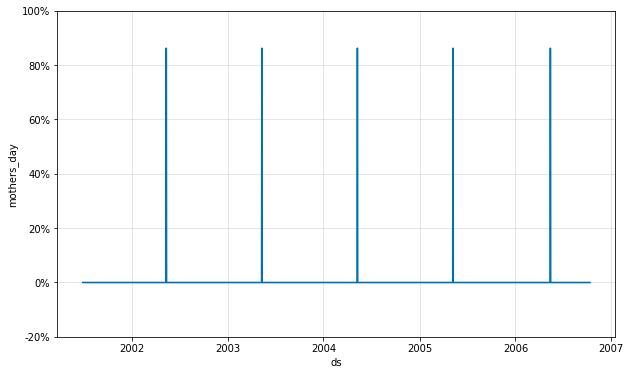

In [25]:
plot_forecast_component(m_02, future_forecast, 'mothers_day')
#A huge increase of customers around 85% on average on Valentines Day

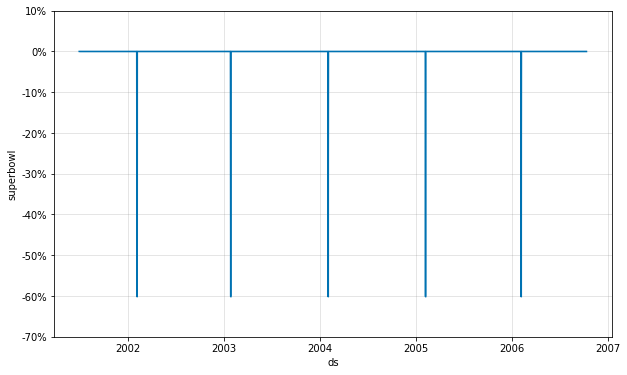

In [23]:
plot_forecast_component(m_02, future_forecast, 'superbowl')
#A decrease on avg of 60% on Superbowl Sunday

In [160]:
#The holiday effect can be seen in the forecast dataframe:
#This just provides the holiday effect in a nice table.
future_forecast[(future_forecast['superbowl'] + future_forecast['valentines_day'] + future_forecast['mothers_day'] + future_forecast['halloween'] + future_forecast['christmas_eve'] + future_forecast['newyears_eve']).abs() > 0][
        ['ds', 'superbowl', 'valentines_day', 'mothers_day', 'halloween', 'christmas_eve', 'newyears_eve']]

,ds,superbowl,valentines_day,mothers_day,halloween,christmas_eve,newyears_eve
125,2001-10-31,0.000000,0.000000,0.000000,-0.343876,0.000000,0.00000
178,2001-12-24,0.000000,0.000000,0.000000,0.000000,0.717578,0.00000
184,2001-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.76971
218,2002-02-03,-0.601581,0.000000,0.000000,0.000000,0.000000,0.00000
229,2002-02-14,0.000000,0.922987,0.000000,0.000000,0.000000,0.00000
316,2002-05-12,0.000000,0.000000,0.862058,0.000000,0.000000,0.00000
487,2002-10-31,0.000000,0.000000,0.000000,-0.343876,0.000000,0.00000
540,2002-12-24,0.000000,0.000000,0.000000,0.000000,0.717578,0.00000
546,2002-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.76971
572,2003-01-26,-0.601581,0.000000,0.000000,0.000000,0.000000,0.00000


In [ ]:
#Plot future forecast
fig_c_model = m_02.plot(future_forecast)
add_changepoints_to_plot(fig_c_model.gca(), m_02, future_forecast)
plt.show()

# Model Performance

In [161]:
from prophet.diagnostics import cross_validation

In [165]:
df_cv = cross_validation(m_02,
                         horizon='365 days',
                         period='180 days',
                         initial='900 days',
                        parallel='processes')

INFO:prophet:Making 2 forecasts with cutoffs between 2004-04-15 00:00:00 and 2004-10-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcecce16d30>


Initial log joint probability = -19.7996
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.4415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2358.48     0.0152347       304.098           1           1      121   
      99       2767.67     0.0025047       70.3974           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156        2768.8   0.000209345        116.37   2.872e-06       0.001      230  LS failed, Hessian reset 
     199       2768.92   4.04188e-06       68.3232      0.2408      0.2408      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       2360.97   0.000354372       156.504   4.015e-06       0.001      280  L

In [166]:
#Print cross-validated df
print(df_cv.head())

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 2004-04-16  537.792297  465.874492  609.655872  540 2004-04-15
1 2004-04-17  590.648622  526.865472  661.262428  507 2004-04-15
2 2004-04-18  393.406884  323.078865  459.161718  354 2004-04-15
3 2004-04-19  263.449687  196.504981  338.416564  230 2004-04-15
4 2004-04-20  287.881369  216.653121  357.549380  264 2004-04-15


In [167]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,6539.892823,80.869604,44.589086,0.114751,0.081245,0.112821,0.847222
1,37 days,6496.129703,80.598571,44.213906,0.113466,0.075809,0.111282,0.847222
2,38 days,6418.090684,80.112987,43.372888,0.111176,0.070350,0.109269,0.861111
3,39 days,6202.802426,78.757872,41.988566,0.110662,0.069186,0.108102,0.875000
4,40 days,2158.007168,46.454356,34.587282,0.103379,0.067858,0.098600,0.888889


/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


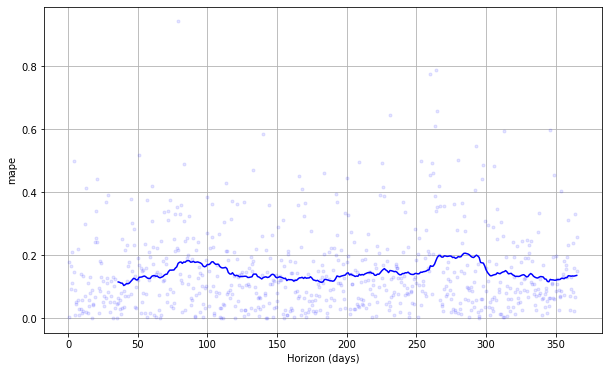

In [168]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


Cross validation performance metrics can be visualized with plot_cross_validation_metric, here shown for MAPE. Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 11% are typical for predictions one month into the future, and that errors increase significantly to over 20% for predictions 8 months out.

In [ ]:
m_02 = Prophet(holidays = holidays, seasonality_mode='multiplicative', yearly_seasonality = 3)

#Add country holidays
m_02.add_country_holidays(country_name='US')

#Fit model
m_02.fit(df)

In [170]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       3675.51   2.99609e-07       4962.31   5.992e-11       0.001      145  LS failed, Hessian reset 
      94       3675.51   9.43462e-09       4963.09      0.6037      0.6037      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced1b73250>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       703.981   6.61504e-09       5005.05      0.2203      0.2203       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       667.303   1.67386e-09       5030.59     0.04486     0.04486       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       612.282   9.31394e-09       4988.03      0.2639      0.2639       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

Iteration  1. Log joint probability =     433.17. Improved by 600.451.
Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -182.927
Iteration  2. Log joint probability =    668.248. Improved by 235.079.


Iteration  3. Log joint probability =    675.352. Improved by 7.10345.
Iteration  1. Log joint probability =    402.571. Improved by 585.498.
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       875.921   0.000129345       4835.63   2.529e-08       0.001      138  LS failed, Hessian reset 
Iteration  4. Log joint probability =    735.238. Improved by 59.8863.
      99       876.855   2.30822e-06       4692.64      0.5855      0.5855      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       876.877   5.73581e-09       4798.94      0.8824      0.8824      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    649.958. Improved by 247.387.
Iteration  5. Log joint probability =    781.975. Improved by 46.7367.
Iteration  3. Log joint probab

Iteration 33. Log joint probability =    808.067. Improved by 2.62315e-06.
Iteration  1. Log joint probability =     317.02. Improved by 528.784.
Iteration 26. Log joint probability =     844.05. Improved by 8.83849e-05.
Iteration 34. Log joint probability =    808.067. Improved by 8.74849e-07.
Iteration 27. Log joint probability =     844.05. Improved by 2.42281e-05.
Iteration  2. Log joint probability =    692.289. Improved by 375.27.
Iteration 35. Log joint probability =    808.067. Improved by 8.2116e-09.
Iteration 28. Log joint probability =     844.05. Improved by 4.46729e-06.
Iteration  3. Log joint probability =    880.318. Improved by 188.029.
Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.2233             0       498.642       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be mad

Iteration 30. Log joint probability =     844.05. Improved by 5.15858e-06.
Iteration  1. Log joint probability =    357.893. Improved by 581.661.
Iteration  5. Log joint probability =    903.009. Improved by 14.3318.
Iteration 31. Log joint probability =     844.05. Improved by 6.561e-06.
Iteration  6. Log joint probability =     905.27. Improved by 2.26116.
Iteration  2. Log joint probability =    771.921. Improved by 414.028.
Iteration 32. Log joint probability =     844.05. Improved by 1.63351e-06.
Iteration  7. Log joint probability =    908.893. Improved by 3.62281.
Iteration  3. Log joint probability =    905.713. Improved by 133.793.
Iteration  8. Log joint probability =    909.529. Improved by 0.636591.
Iteration 33. Log joint probability =     844.05. Improved by 4.07604e-06.
Iteration  9. Log joint probability =    909.737. Improved by 0.207431.
Iteration  4. Log joint probability =    926.145. Improved by 20.4318.
Iteration 34. Log joint probability =     844.05. Improved by

Iteration  1. Log joint probability =    450.662. Improved by 729.173.
Iteration  2. Log joint probability =    661.733. Improved by 211.071.
Iteration  3. Log joint probability =    934.593. Improved by 272.86.
Iteration  4. Log joint probability =     1021.8. Improved by 87.2062.
Iteration  5. Log joint probability =    1022.86. Improved by 1.06114.
Iteration  6. Log joint probability =     1039.3. Improved by 16.4392.
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -296.321
Iteration  7. Log joint probability =    1039.98. Improved by 0.676526.


Iteration  8. Log joint probability =    1040.99. Improved by 1.01343.
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1179             0       587.417       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -307.529
Iteration  1. Log joint probability =    481.415. Improved by 777.736.
Iteration  9. Log joint probability =    1041.39. Improved by 0.3997.


Iteration  2. Log joint probability =    503.782. Improved by 22.3668.
Iteration  1. Log joint probability =    527.682. Improved by 835.211.
Iteration 10. Log joint probability =    1041.56. Improved by 0.168119.
Iteration 11. Log joint probability =    1041.79. Improved by 0.23535.
Iteration  3. Log joint probability =    1022.84. Improved by 519.056.
Iteration  2. Log joint probability =    828.857. Improved by 301.175.
Iteration 12. Log joint probability =    1041.95. Improved by 0.154966.
Iteration  4. Log joint probability =    1062.36. Improved by 39.5249.
Iteration  3. Log joint probability =    958.235. Improved by 129.378.
Iteration 13. Log joint probability =    1041.95. Improved by 0.00597355.
Iteration  5. Log joint probability =     1065.5. Improved by 3.1337.
Iteration  4. Log joint probability =    1067.43. Improved by 109.193.
Iteration 14. Log joint probability =    1042.02. Improved by 0.0668326.
Iteration  6. Log joint probability =    1065.92. Improved by 0.420777.


Initial log joint probability = -339.405
Iteration 12. Log joint probability =    1067.01. Improved by 0.0350442.
Iteration 22. Log joint probability =    1042.11. Improved by 0.00146396.
Iteration 12. Log joint probability =    1096.22. Improved by 0.0880888.
Iteration 23. Log joint probability =    1042.11. Improved by 0.00061976.
Iteration 13. Log joint probability =    1067.09. Improved by 0.0834982.
Iteration  1. Log joint probability =    430.624. Improved by 770.029.
Iteration 13. Log joint probability =    1096.53. Improved by 0.313579.
Iteration 24. Log joint probability =    1042.11. Improved by 0.000858585.
Iteration 14. Log joint probability =    1067.12. Improved by 0.0321085.
Iteration 14. Log joint probability =    1096.64. Improved by 0.104183.
Iteration  2. Log joint probability =    761.926. Improved by 331.302.
Iteration 25. Log joint probability =    1042.11. Improved by 0.000137862.
Iteration 15. Log joint probability =    1096.68. Improved by 0.0456901.
Iteration

Iteration 43. Log joint probability =    1096.82. Improved by 5.46275e-07.
Iteration 30. Log joint probability =    1097.62. Improved by 0.000136733.
Iteration 40. Log joint probability =    1067.17. Improved by 1.8981e-06.
Iteration 44. Log joint probability =    1096.82. Improved by 1.24776e-06.
Iteration 31. Log joint probability =    1097.62. Improved by 6.27835e-05.
Iteration 41. Log joint probability =    1067.17. Improved by 9.8362e-06.
Iteration 45. Log joint probability =    1096.82. Improved by 3.90241e-07.
Iteration 32. Log joint probability =    1097.62. Improved by 9.43827e-06.
Iteration 42. Log joint probability =    1067.17. Improved by 4.29836e-05.
Iteration 46. Log joint probability =    1096.82. Improved by 2.44369e-07.
Iteration 33. Log joint probability =    1097.62. Improved by 3.1086e-05.
Iteration 43. Log joint probability =    1067.17. Improved by 9.79299e-06.
Iteration 47. Log joint probability =    1096.82. Improved by 1.34225e-07.
Iteration 34. Log joint prob

Iteration  1. Log joint probability =    562.994. Improved by 957.93.
Iteration  2. Log joint probability =    938.381. Improved by 375.387.
Iteration  3. Log joint probability =    1200.43. Improved by 262.047.
Iteration  4. Log joint probability =    1203.08. Improved by 2.65211.
Iteration  5. Log joint probability =    1226.79. Improved by 23.713.
Iteration  6. Log joint probability =    1226.95. Improved by 0.153175.
Iteration  7. Log joint probability =    1228.22. Improved by 1.27348.
Iteration  8. Log joint probability =    1230.07. Improved by 1.84653.
Iteration  9. Log joint probability =    1231.11. Improved by 1.04201.
Iteration 10. Log joint probability =     1236.5. Improved by 5.39476.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68          1282   9.99498e-09       4966.85      0.4279      0.4279       88   
Optimization terminated normally: 
  Convergence detected: absolute par

Initial log joint probability = -15.3449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       1560.71   6.08684e-07       4852.58   1.237e-10       0.001      153  LS failed, Hessian reset 
      99       1560.72   3.71538e-08       4472.27           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1560.72   8.32564e-09        4858.2      0.6134      0.6134      181   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1581.97   5.80289e-09       5050.31      0.3524      0.3524       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log p

     281       1624.76   8.62872e-09       5760.93       0.409       0.409      429   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    589.395. Improved by 1168.66.
Iteration  2. Log joint probability =    1181.83. Improved by 592.438.
Iteration  3. Log joint probability =    1607.65. Improved by 425.82.
Iteration  4. Log joint probability =    1638.31. Improved by 30.6603.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    1646.59. Improved by 8.2761.
      99       1704.85    0.00109865       5259.12      0.3803      0.3803      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       1710.75   7.00428e-09       4509.24      0.2482      0.2482      200   
Optimization terminated normally: 
  Convergence detecte

Iteration 54. Log joint probability =    1684.53. Improved by 1.85571e-06.
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       2009.69   9.95142e-09       4536.63           1           1      104   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 55. Log joint probability =    1684.53. Improved by 6.9388e-07.
Iteration 56. Log joint probability =    1684.53. Improved by 9.49552e-07.
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 57. Log joint probability =    1684.53. Improved by 4.1694e-08.
      92       2044.58   0.000133215       5077.29   2.611e-08       0.001      159  LS failed, Hessian reset 
      99       2045.12   3.23839e-05       4892.68      0.2296           1      168   
    Iter      log prob        ||dx||      ||gr

Iteration  1. Log joint probability =    578.247. Improved by 1495.65.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       2606.99   4.62983e-09       4713.14      0.1994      0.1994      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       2634.64   0.000824424       4560.04      0.5042      0.5042      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    1492.94. Improved by 914.69.
     199       2638.71   3.95841e-07       4979.75           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       2638.71     9.574e-09       

      55       2904.07   0.000143456       4071.93   2.971e-08       0.001      104  LS failed, Hessian reset 
Iteration 41. Log joint probability =    2384.72. Improved by 1.00261e-05.
      97        2904.8   8.08872e-06       4939.03   1.557e-09       0.001      190  LS failed, Hessian reset 
      99       2904.82   3.35494e-06       4297.86           1           1      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       2907.46   8.55467e-09       4737.82      0.3071      0.3071      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 42. Log joint probability =    2384.72. Improved by 4.07475e-06.
Iteration 43. Log joint probability =    2384.72. Improved by 7.59476e-07.
Iteration 44. Log joint probability =    2384.72. Improved by 2.36036e-06.
Iteration 45. Log joint probability =    2384.72. Improved by 1.17288e-06.
Iteration 46. Log joint probabil


Initial log joint probability = -1220.28
Iteration  1. Log joint probability =    775.752. Improved by 1996.03.
Iteration  2. Log joint probability =    1453.58. Improved by 677.824.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       3438.77    7.1752e-09       4820.49      0.4298      0.4298       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =     2207.6. Improved by 754.02.
Iteration  4. Log joint probability =     2208.1. Improved by 0.508073.
Iteration  5. Log joint probability =    2209.44. Improved by 1.33938.
Iteration  6. Log joint probability =    2211.11. Improved by 1.66512.
Iteration  7. Log joint probability =     2213.5. Improved by 2.39351.
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

Iteration 79. Log joint probability =    3405.78. Improved by 2.77857e-07.
Iteration 80. Log joint probability =    3405.78. Improved by 2.44395e-08.
Iteration 81. Log joint probability =    3405.78. Improved by 1.38331e-07.
Iteration 82. Log joint probability =    3405.78. Improved by 3.07e-08.
Iteration 83. Log joint probability =    3405.78. Improved by 3.27327e-09.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       3745.11   9.69073e-09       5034.73      0.3677      0.3677       84   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcece0b4af0>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       809.997   9.78856e-09       4819.11      0.3564           1       99   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       777.279   6.75229e-09       4963.93      0.1262      0.1262       83   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       765.218   1.58809e-06       4971.84      0.3834           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       765.234   2.55087e-07  

Iteration  1. Log joint probability =    446.829. Improved by 673.977.
Iteration  2. Log joint probability =    576.319. Improved by 129.49.
Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -242.794
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    833.573. Improved by 257.254.
      96       1006.23    7.1921e-09       5071.87      0.3392      0.9947      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Iteration  4. Log joint probability =     921.41. Improved by 87.8369.
Iteration  1. Log joint probability =    373.299. Improved by 616.094.
Iteration  5. Log joint probability =    926.376. Improved by 4.96664.
Iteration  2. Log joint probability =    688.989. Improved by 315.69.
Iteration  6. Log joint probability =    944.143. Improved by 17.7669.
Iteration  7. Log joint probability =    944.925. Improved by 0.781848.
Iteration  3. Log joint probability =    920.987. Improved by 231.997.
Iteration  8. Log joint probability =    945.452. Improved by 0.526594.
Iteration  4. Log joint probability =    974.231. Improved by 53.2444.
Iteration  9. Log joint probability =    945.768. Improved by 0.315881.
Iteration 10. Log joint probability =    945.865. Improved by 0.0973796.
Iteration  5. Log joint probability =    981.598. Improved by 7.36693.
Iteration 11. Log joint probability =    945.895. Improved by 0.0300193.
Iteration  6. Log joint probability =    983.432. Improved by 1.8336.
I

Iteration 34. Log joint probability =     946.04. Improved by 2.0994e-06.
Iteration 24. Log joint probability =    983.903. Improved by 1.68065e-05.
Iteration  1. Log joint probability =    463.831. Improved by 735.463.
Iteration 35. Log joint probability =     946.04. Improved by 4.51734e-07.
Iteration 25. Log joint probability =    983.903. Improved by 3.19084e-06.
Iteration  2. Log joint probability =    751.655. Improved by 287.824.
Iteration 36. Log joint probability =     946.04. Improved by 9.23233e-07.
Initial log joint probability = -10.2233
Iteration 26. Log joint probability =    983.904. Improved by 1.61001e-05.
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.2233             0       498.642       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -283.635
Iteration  3. Log joint pr

Iteration 27. Log joint probability =    983.904. Improved by 3.8961e-06.
Iteration 38. Log joint probability =     946.04. Improved by 4.56286e-07.
Iteration  4. Log joint probability =     1040.5. Improved by 5.76181.
Iteration  1. Log joint probability =    465.374. Improved by 749.009.
Iteration 39. Log joint probability =     946.04. Improved by 1.53127e-07.
Iteration 28. Log joint probability =    983.904. Improved by 1.53936e-05.
Iteration  5. Log joint probability =    1042.47. Improved by 1.97116.
Iteration  2. Log joint probability =     834.94. Improved by 369.566.
Iteration 40. Log joint probability =     946.04. Improved by 2.05857e-07.
Iteration 29. Log joint probability =    983.904. Improved by 4.60138e-06.
Iteration  6. Log joint probability =    1042.74. Improved by 0.269197.
Iteration 41. Log joint probability =     946.04. Improved by 4.7558e-08.
Iteration  7. Log joint probability =    1052.45. Improved by 9.70655.
Iteration  3. Log joint probability =    1054.51. 

Iteration 60. Log joint probability =    983.904. Improved by 1.40276e-05.
      87       1102.45   3.28939e-05       5126.94   6.522e-09       0.001      151  LS failed, Hessian reset 
      99       1102.59   3.04571e-06       5161.48      0.6803      0.6803      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       1102.72    6.1499e-06       5136.24   1.227e-09       0.001      250  LS failed, Hessian reset 
Iteration 37. Log joint probability =    1087.22. Improved by 0.00406702.
     155       1102.75    4.5253e-09       4991.97      0.3242      0.3242      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 61. Log joint probability =    983.904. Improved by 6.01301e-06.
Iteration 38. Log joint probability =    1087.23. Improved by 0.00188478.
Iteration 62. Log joint probability =    983.904. Improved by 1.29657e-05.
Iteration 39. Log joint probabilit

Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration 112. Log joint probability =    983.904. Improved by 4.91062e-06.

Initial log joint probability = -356.188
Iteration  1. Log joint probability =    515.866. Improved by 854.246.


Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1179             0       587.417       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -367.396
Iteration 113. Log joint probability =    983.904. Improved by 2.00383e-05.
Iteration  1. Log joint probability =    125.609. Improved by 481.797.
Iteration  2. Log joint probability =     852.98. Improved by 337.113.


Iteration 114. Log joint probability =    983.904. Improved by 7.77287e-08.
Iteration  1. Log joint probability =    520.788. Improved by 888.185.
Iteration  2. Log joint probability =    391.736. Improved by 266.127.
Iteration  3. Log joint probability =    1137.23. Improved by 284.252.
Iteration 115. Log joint probability =    983.904. Improved by 2.29724e-06.
Iteration  2. Log joint probability =    958.979. Improved by 438.191.
Iteration  3. Log joint probability =    813.104. Improved by 421.368.
Iteration 116. Log joint probability =    983.904. Improved by 2.27933e-07.
Iteration  4. Log joint probability =    1151.87. Improved by 14.6409.
Iteration  4. Log joint probability =      821.2. Improved by 8.09632.
Iteration 117. Log joint probability =    983.904. Improved by 2.14702e-06.
Iteration  5. Log joint probability =    1153.48. Improved by 1.60328.
Iteration  3. Log joint probability =    1198.89. Improved by 239.908.
Iteration 118. Log joint probability =    983.904. Improv

Iteration 25. Log joint probability =    900.376. Improved by 1.37848.
Iteration 146. Log joint probability =    983.904. Improved by 2.31236e-06.
Iteration 31. Log joint probability =    1182.33. Improved by 0.000498564.
Iteration 31. Log joint probability =    1240.95. Improved by 2.23948e-05.
Iteration 147. Log joint probability =    983.904. Improved by 9.62652e-07.
Iteration 32. Log joint probability =    1182.33. Improved by 0.000180946.
Iteration 26. Log joint probability =    906.529. Improved by 6.15343.
Iteration 32. Log joint probability =    1240.95. Improved by 4.42688e-06.
Iteration 148. Log joint probability =    983.904. Improved by 1.65574e-07.
Iteration 33. Log joint probability =    1182.33. Improved by 0.000301095.
Iteration 27. Log joint probability =    913.501. Improved by 6.9716.
Iteration 33. Log joint probability =    1240.95. Improved by 2.75493e-06.
Iteration 149. Log joint probability =    983.904. Improved by 6.35208e-07.
Iteration 34. Log joint probabilit

Iteration  1. Log joint probability =    421.278. Improved by 820.55.
Iteration 59. Log joint probability =    1208.89. Improved by 0.00855759.
Iteration  2. Log joint probability =    745.229. Improved by 323.951.
Iteration 60. Log joint probability =    1208.92. Improved by 0.0331376.
Iteration 61. Log joint probability =    1208.93. Improved by 0.00589229.
Iteration  3. Log joint probability =    904.973. Improved by 159.744.
Iteration 62. Log joint probability =    1208.95. Improved by 0.0220963.
Initial log joint probability = -9.56055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    1202.88. Improved by 297.912.
      75        1260.9   3.36716e-05       5064.19   6.715e-09       0.001      146  LS failed, Hessian reset 
Iteration 63. Log joint probability =    1208.95. Improved by 0.00724833.
      99       1261.13   8.42704e-07       5033.03           1           1      178   
    Iter      log 

Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       1424.61   9.26336e-09       4723.47      0.2705           1      113   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =    527.929. Improved by 982.732.
Iteration  2. Log joint probability =    1041.99. Improved by 514.06.
Iteration  3. Log joint probability =    1160.69. Improved by 118.699.
Iteration  4. Log joint probability =    1190.02. Improved by 29.3315.
Iteration  5. Log joint probability =     1366.3. Improved by 176.281.
Iteration  6. Log joint probability =    1384.52. Improved by 18.219.
Iteration  7. Log joint probability =    1389.21. Improved by 4.69231.
Iteration  8. Log joint probability =    1400.58. Improved by 11.3689.
Iteration  9. Log joint probability =    1403.72. Improved by 3.13993.
Iteration 10. Log joint probability = 

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       1748.37   3.08128e-06       4514.08   6.404e-10       0.001      137  LS failed, Hessian reset 
      99       1748.39   6.77833e-07       4626.69      0.9214      0.9214      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       1748.39   8.49263e-09       4523.96      0.2852      0.2852      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1775.28   4.30656e-05       5133.31      0.3494      0.3494      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1791.44   0.000170778       5061.94    3.36e-08       0.00

Iteration  1. Log joint probability =    713.225. Improved by 1352.36.
Iteration  2. Log joint probability =    1409.62. Improved by 696.391.
Iteration  3. Log joint probability =    1768.46. Improved by 358.844.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1841.37   1.07093e-05       5496.39   2.287e-09       0.001      140  LS failed, Hessian reset 
      99       1841.39   4.10122e-07       4165.17      0.2633      0.6819      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    1795.39. Improved by 26.9305.
     145       1841.43   3.53511e-06       4340.76   6.667e-10       0.001      243  LS failed, Hessian reset 
     181       1841.44   1.75845e-09       5059.89      0.1126      0.1126      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below 

Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       2154.56   0.000136293       4997.76   2.699e-08       0.001      174  LS failed, Hessian reset 
      99       2155.19   5.42082e-05       4797.06       0.962       0.962      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       2155.48   6.30641e-06       4504.01    1.17e-09       0.001      297  LS failed, Hessian reset 
     199       2155.52   2.12118e-07       4972.07           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2155.52   6.64201e-09       5001.53    0.006535           1      353   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||    

Iteration  1. Log joint probability =     830.01. Improved by 1807.28.
Iteration  2. Log joint probability =    1608.28. Improved by 778.27.
Iteration  3. Log joint probability =    2248.99. Improved by 640.712.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    2526.25. Improved by 277.257.
      78       2717.44   3.48133e-09       4767.14      0.2685      0.2685      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  5. Log joint probability =    2526.82. Improved by 0.575641.
Iteration  6. Log joint probability =    2528.37. Improved by 1.54873.
Iteration  7. Log joint probability =    2528.56. Improved by 0.184255.
Iteration  8. Log joint probability =     2528.8. Improved by 0.244381.
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha  

     175       2982.83    9.3684e-07       4792.01   1.865e-10       0.001      261  LS failed, Hessian reset 
Iteration 42. Log joint probability =    2529.37. Improved by 2.07491e-06.
     195       2982.84   2.38449e-09       4833.59      0.2734      0.2734      288   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 43. Log joint probability =    2529.37. Improved by 5.22768e-07.
Iteration 44. Log joint probability =    2529.37. Improved by 1.07607e-06.
Iteration 45. Log joint probability =    2529.37. Improved by 3.79623e-09.
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3021.02   2.61411e-08       4551.34      0.6759      0.6759      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3021.02   1.82095e-09       4855.08      0.1938      0.1938      136  

Iteration  1. Log joint probability =    167.393. Improved by 1447.54.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    1463.86. Improved by 1296.47.
      56       3511.14   9.19451e-09       4943.47      0.0694           1       78   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    1728.27. Improved by 264.408.
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       3536.48   0.000114879       5048.27   2.268e-08       0.001      140  LS failed, Hessian reset 
      99       3536.99   6.91956e-08       4920.02      0.2966      0.2966      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       3536.99   7.88545e-09   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        3746.1   7.25909e-09       5008.19      0.2082           1       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced17f3730>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       757.926    6.1662e-09       5086.74      0.6132      0.6132      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       853.331    6.2756e-09       4952.75      0.2459      0.2459      105   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       779.706   3.27503e-10       5064.28   0.0005803       0.855      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

Iteration  1. Log joint probability =    389.411. Improved by 676.427.
Iteration  1. Log joint probability =    361.244. Improved by 663.905.
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    718.607. Improved by 329.196.
      99          1003   3.23199e-07       4956.38           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117          1003   9.45136e-09       4982.82      0.5752      0.5752      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  2. Log joint probability =    675.274. Improved by 314.03.
Iteration  3. Log joint probability =    891.363. Improved by 172.756.
Iteration  3. Log joint probability =    935.154. Improved by 259.881.
Iteration  4. Log joint probability =    897.355. Improved by 5.99203.


Iteration  1. Log joint probability =    289.149. Improved by 620.647.
Iteration 29. Log joint probability =    985.908. Improved by 0.000142651.
Iteration 29. Log joint probability =    947.745. Improved by 4.86701e-05.
Iteration 30. Log joint probability =    985.908. Improved by 2.17232e-05.
Iteration  2. Log joint probability =     769.46. Improved by 480.312.
Iteration 30. Log joint probability =    947.745. Improved by 7.42183e-05.
Iteration 31. Log joint probability =    985.908. Improved by 7.56197e-05.
Iteration 31. Log joint probability =    947.745. Improved by 1.90213e-05.
Initial log joint probability = -10.2233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.2233             0       498.642       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made
Iteration  3. Log joint probability =    1000.65. Improved by 231.1

Iteration 32. Log joint probability =    947.745. Improved by 1.80691e-05.
Iteration  4. Log joint probability =    1051.25. Improved by 50.604.
Iteration  1. Log joint probability =    462.257. Improved by 805.759.
Iteration 33. Log joint probability =    985.908. Improved by 6.36901e-06.
Iteration 33. Log joint probability =    947.745. Improved by 2.21891e-06.
Iteration  5. Log joint probability =    1053.13. Improved by 1.87462.
Iteration 34. Log joint probability =    985.908. Improved by 1.53357e-05.
Iteration 34. Log joint probability =    947.745. Improved by 8.44996e-06.
Iteration  2. Log joint probability =    725.163. Improved by 262.906.
Iteration 35. Log joint probability =    985.908. Improved by 2.62367e-06.
Iteration  6. Log joint probability =    1053.26. Improved by 0.131099.
Iteration 35. Log joint probability =    947.745. Improved by 6.48464e-07.
Iteration  3. Log joint probability =    1020.65. Improved by 295.49.
Iteration 36. Log joint probability =    985.908. 

Iteration 42. Log joint probability =    1053.97. Improved by 0.000433331.
Initial log joint probability = -7.82831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 43. Log joint probability =    1053.97. Improved by 0.0020205.
Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1113.11   6.81566e-07       4991.21      0.6588      0.6588      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1117.49    7.4446e-09        4981.4     0.08337     0.08337      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       1138.61   2.63879e-07       4583.01      0.5622      0.5622      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       1138.61   4.65285e-09

Iteration 70. Log joint probability =       1054. Improved by 0.00109167.
Iteration  1. Log joint probability =    495.065. Improved by 893.311.
Iteration  1. Log joint probability =    504.695. Improved by 920.751.
Iteration 71. Log joint probability =       1054. Improved by 0.00119925.
Iteration  2. Log joint probability =    864.524. Improved by 369.459.
Iteration 72. Log joint probability =       1054. Improved by 0.00106635.
Iteration  2. Log joint probability =    837.852. Improved by 333.158.
Iteration 73. Log joint probability =       1054. Improved by 0.00118652.
Iteration  3. Log joint probability =    1128.17. Improved by 263.65.
Iteration  3. Log joint probability =    1111.25. Improved by 273.402.
Iteration 74. Log joint probability =       1054. Improved by 0.00110224.
Iteration  4. Log joint probability =    1174.39. Improved by 46.2209.
Iteration  4. Log joint probability =    1136.53. Improved by 25.2716.
Iteration 75. Log joint probability =       1054. Improved by 0

Iteration 94. Log joint probability =    1054.03. Improved by 0.00148025.
Iteration 23. Log joint probability =    1210.67. Improved by 0.00141774.
Iteration 23. Log joint probability =    1184.09. Improved by 7.87377e-05.
Iteration  1. Log joint probability =    51.6866. Improved by 478.95.
Iteration 95. Log joint probability =    1054.03. Improved by 0.000651708.
Iteration 24. Log joint probability =    1210.68. Improved by 0.00063892.
Iteration 24. Log joint probability =    1184.09. Improved by 2.74274e-05.
Iteration  2. Log joint probability =    753.721. Improved by 702.035.
Iteration 96. Log joint probability =    1054.03. Improved by 0.00156853.
Iteration 25. Log joint probability =    1210.68. Improved by 0.000929557.
Iteration 25. Log joint probability =    1184.09. Improved by 7.50113e-06.
Iteration 26. Log joint probability =    1210.68. Improved by 1.89257e-05.
Iteration 97. Log joint probability =    1054.03. Improved by 0.000547766.
Iteration  3. Log joint probability = 

Iteration 128. Log joint probability =    1054.06. Improved by 0.00201514.
Iteration 29. Log joint probability =    1242.77. Improved by 0.0412552.
Iteration 129. Log joint probability =    1054.07. Improved by 0.00435284.
Iteration 30. Log joint probability =     1242.8. Improved by 0.0255591.
Iteration 130. Log joint probability =    1054.07. Improved by 0.00178801.
Iteration 31. Log joint probability =    1242.82. Improved by 0.0211021.
Iteration 131. Log joint probability =    1054.07. Improved by 0.00230247.
Iteration 32. Log joint probability =    1242.83. Improved by 0.00753955.
Iteration 132. Log joint probability =    1054.07. Improved by 0.00122737.
Iteration 33. Log joint probability =    1242.83. Improved by 0.0038601.
Iteration 133. Log joint probability =    1054.07. Improved by 6.7652e-06.
Iteration 134. Log joint probability =    1054.07. Improved by 0.000247131.
Iteration 34. Log joint probability =    1242.83. Improved by 0.000791767.
Iteration 135. Log joint probabil

Iteration 41. Log joint probability =    1242.84. Improved by 0.000116279.
Iteration 142. Log joint probability =    1054.07. Improved by 0.000223408.
Iteration 143. Log joint probability =    1054.07. Improved by 3.63089e-05.
Iteration 42. Log joint probability =    1242.84. Improved by 1.11473e-05.
Iteration  1. Log joint probability =     454.36. Improved by 913.499.
Iteration 144. Log joint probability =    1054.07. Improved by 0.000207726.
Iteration 43. Log joint probability =    1242.84. Improved by 7.09115e-05.
Iteration  2. Log joint probability =    804.675. Improved by 350.316.
Iteration 145. Log joint probability =    1054.07. Improved by 5.5024e-05.
Iteration 44. Log joint probability =    1242.84. Improved by 1.28191e-05.
Iteration  3. Log joint probability =    1151.12. Improved by 346.442.
Iteration 146. Log joint probability =    1054.07. Improved by 0.000188888.
Iteration 45. Log joint probability =    1242.84. Improved by 3.21737e-05.
Iteration 147. Log joint probabil

Iteration 184. Log joint probability =    1054.08. Improved by 5.62164e-07.
Iteration 37. Log joint probability =    1246.92. Improved by 1.68626e-05.
Iteration 185. Log joint probability =    1054.08. Improved by 1.34863e-06.
Iteration 38. Log joint probability =    1246.92. Improved by 1.76036e-06.
Iteration 186. Log joint probability =    1054.08. Improved by 6.77948e-07.
Iteration 187. Log joint probability =    1054.08. Improved by 1.23284e-06.
Iteration 39. Log joint probability =    1246.92. Improved by 8.39717e-06.
Iteration 188. Log joint probability =    1054.08. Improved by 7.73648e-07.
Iteration 40. Log joint probability =    1246.92. Improved by 1.89396e-06.
Iteration 189. Log joint probability =    1054.08. Improved by 1.15665e-06.
Iteration 41. Log joint probability =    1246.92. Improved by 3.98217e-06.
Iteration 190. Log joint probability =    1054.08. Improved by 8.25763e-07.
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||   

Iteration 217. Log joint probability =    1054.08. Improved by 8.52219e-09.
Iteration  1. Log joint probability =    583.859. Improved by 1098.53.
Iteration  2. Log joint probability =    970.202. Improved by 386.343.
Iteration  3. Log joint probability =    1344.98. Improved by 374.774.
Iteration  4. Log joint probability =    1397.98. Improved by 53.0047.
Iteration  5. Log joint probability =    1405.71. Improved by 7.7322.
Iteration  6. Log joint probability =    1405.82. Improved by 0.1114.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1428.91   9.38953e-07       5149.04   1.874e-10       0.001      154  LS failed, Hessian reset 
      99       1428.91   1.29529e-07       4859.08      0.2456           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       1428.91   7.40962e-09        4959.8      0.2529      0.2529   

Initial log joint probability = -15.3449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1717.42   5.56102e-07       4905.02           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1717.43   6.36408e-09       4877.15     0.05571     0.05571      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       1742.38   4.65003e-09       4725.15      0.1853      0.4383      101   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1791.76   2.60459e-05  

Iteration  1. Log joint probability =    779.853. Improved by 1478.85.
Iteration  2. Log joint probability =    1324.87. Improved by 545.018.
Iteration  3. Log joint probability =    1727.92. Improved by 403.052.
Iteration  4. Log joint probability =    1742.18. Improved by 14.2603.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    1811.56. Improved by 69.3777.
      99        1843.2    1.1293e-06       5677.91      0.4389           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       1843.21   8.41658e-09       5038.56      0.5391      0.5391      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.3759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65

     174       2195.46   9.13615e-09        4698.8      0.5667      0.5667      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.4254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       2224.22   2.98562e-05       5010.24   5.951e-09       0.001      100  LS failed, Hessian reset 
      78       2224.38   6.58369e-09       5053.46      0.4528      0.4528      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       2260.89    0.00130761       4959.02           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       2261.75   6.51472e-09       5020.18      0.503

Iteration  1. Log joint probability =    817.698. Improved by 1854.84.
Iteration  2. Log joint probability =    1606.88. Improved by 789.18.
Iteration  3. Log joint probability =    2292.99. Improved by 686.114.
Iteration  4. Log joint probability =    2516.22. Improved by 223.226.
Iteration  5. Log joint probability =    2518.13. Improved by 1.91523.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  6. Log joint probability =    2523.97. Improved by 5.84177.
      86       2718.84    3.4106e-06       4734.16   6.784e-10       0.001      162  LS failed, Hessian reset 
      99       2718.86   4.57649e-07       4757.79       2.329      0.2329      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       2718.86    9.7012e-09       4853.41      0.7966      0.7966      206   
Optimization terminated normally: 
  Convergence detected: absolu

      99       2981.91   1.00719e-06       4939.03           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 45. Log joint probability =    2531.05. Improved by 9.28985e-08.
     183       2981.96   7.11615e-09        4367.8      0.4443      0.4443      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 46. Log joint probability =    2531.05. Improved by 1.38226e-07.
Iteration 47. Log joint probability =    2531.05. Improved by 7.94589e-08.
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3021.78   2.06502e-07       4806.93      0.9887      0.9887      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration 48. Log joint probability =    2531.05. Improved by 2.30107e-08.
     113       30

Iteration  1. Log joint probability =    223.375. Improved by 1563.39.
Iteration  2. Log joint probability =    1476.93. Improved by 1253.56.
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       3511.18   4.09159e-09        4850.3       0.225       0.225       77   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    1791.67. Improved by 314.739.
      99       3538.96   9.82738e-07       4523.85      0.4951      0.4951      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       3538.97   1.57463e-09       5208.24      0.1234      0.1234      167   
Optimization terminated normally: 
  Convergence detected: abso

Iteration 84. Log joint probability =    3446.07. Improved by 0.11407.
Iteration 85. Log joint probability =    3447.54. Improved by 1.46432.
Iteration 86. Log joint probability =    3447.89. Improved by 0.359056.
Iteration 87. Log joint probability =    3448.86. Improved by 0.963581.
Iteration 88. Log joint probability =    3449.51. Improved by 0.648571.
Iteration 89. Log joint probability =    3450.18. Improved by 0.673848.
Iteration 90. Log joint probability =    3451.05. Improved by 0.872548.
Iteration 91. Log joint probability =    3451.36. Improved by 0.305971.
Iteration 92. Log joint probability =    3452.47. Improved by 1.11134.
Iteration 93. Log joint probability =    3454.87. Improved by 2.39848.
Iteration 94. Log joint probability =     3458.3. Improved by 3.4265.
Iteration 95. Log joint probability =    3476.53. Improved by 18.2392.
Iteration 96. Log joint probability =     3476.6. Improved by 0.0625185.
Iteration 97. Log joint probability =    3477.16. Improved by 0.562404

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced375ae20>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       3746.38   9.23357e-09       4952.97      0.3428      0.3428       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70         779.7   6.68493e-09       5064.62       0.193           1      101   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       757.742   6.81979e-06       5047.03   1.348e-09       0.001      144  LS failed, Hessian reset 
      98       757.778   4.17856e-09       5050.54      0.4823      0.4823      178   
Optimization termin

Iteration  1. Log joint probability =     394.21. Improved by 741.093.
Initial log joint probability = -10.7348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -10.7348             0       456.741       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -362.529


Iteration  2. Log joint probability =    712.332. Improved by 318.122.
Iteration  1. Log joint probability =    359.113. Improved by 721.641.
Initial log joint probability = -7.20632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1006.99   7.45534e-07       4962.73           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       1006.99   6.25355e-09       5014.44      0.4326      0.4326      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    791.399. Improved by 79.067.
Iteration  2. Log joint probability =    638.889. Improved by 279.776.
Iteration  4. Log joint probability =     880.43. Improved by 89.0311.
Iteration  3. Log joint probability =    776.112. Improved by 137.223.
Iteration  5. Log joint probability =    900.637. Improved by 20.2078.


Iteration 28. Log joint probability =    985.969. Improved by 0.00103115.
Iteration 28. Log joint probability =    947.268. Improved by 0.63146.
Iteration  1. Log joint probability =    297.029. Improved by 688.395.
Iteration 29. Log joint probability =    985.969. Improved by 4.95064e-05.
Iteration 29. Log joint probability =     947.45. Improved by 0.182856.
Iteration 30. Log joint probability =    985.969. Improved by 0.000488026.
Iteration  2. Log joint probability =    770.563. Improved by 473.534.
Iteration 30. Log joint probability =    947.456. Improved by 0.00602674.
Iteration 31. Log joint probability =    985.969. Improved by 0.000225514.
Iteration 31. Log joint probability =    947.627. Improved by 0.171037.
Iteration  3. Log joint probability =    995.562. Improved by 224.999.
Iteration 32. Log joint probability =     985.97. Improved by 0.000155623.
Iteration 32. Log joint probability =    947.697. Improved by 0.0697853.
Initial log joint probability = -10.2233
    Iter  

Iteration  5. Log joint probability =    1022.22. Improved by 14.9676.
Iteration 34. Log joint probability =     985.97. Improved by 0.000118438.
Iteration  1. Log joint probability =    460.236. Improved by 863.606.
Iteration 34. Log joint probability =    947.753. Improved by 0.0182727.
Iteration 35. Log joint probability =     985.97. Improved by 7.51871e-05.
Iteration  6. Log joint probability =     1038.3. Improved by 16.0808.
Iteration 35. Log joint probability =    947.754. Improved by 0.000586187.
Iteration  2. Log joint probability =    694.517. Improved by 234.281.
Iteration 36. Log joint probability =     985.97. Improved by 3.62705e-05.
Iteration  7. Log joint probability =    1043.35. Improved by 5.04433.
Iteration 36. Log joint probability =    947.763. Improved by 0.00947875.
Iteration 37. Log joint probability =     985.97. Improved by 2.03769e-05.
Iteration  3. Log joint probability =    847.448. Improved by 152.932.
Iteration  8. Log joint probability =    1045.24. Im

Iteration 37. Log joint probability =    1054.62. Improved by 1.25923e-05.
Iteration 32. Log joint probability =    1089.15. Improved by 1.82047e-06.
Iteration 38. Log joint probability =    1054.62. Improved by 5.26118e-06.
Iteration 33. Log joint probability =    1089.15. Improved by 1.17129e-06.
Iteration 39. Log joint probability =    1054.62. Improved by 6.98482e-06.
Iteration 34. Log joint probability =    1089.15. Improved by 4.61457e-07.
Iteration 40. Log joint probability =    1054.62. Improved by 2.18324e-07.
Iteration 35. Log joint probability =    1089.15. Improved by 2.1248e-07.
Iteration 41. Log joint probability =    1054.62. Improved by 5.09228e-06.
Iteration 36. Log joint probability =    1089.15. Improved by 2.06479e-07.
Iteration 42. Log joint probability =    1054.62. Improved by 1.93381e-06.
Iteration 37. Log joint probability =    1089.15. Improved by 1.52798e-07.
Iteration 43. Log joint probability =    1054.62. Improved by 3.93679e-07.
Iteration 38. Log joint pr

Iteration  1. Log joint probability =     492.85. Improved by 950.963.
Iteration  2. Log joint probability =    866.042. Improved by 373.192.
Iteration  3. Log joint probability =    1132.04. Improved by 266.
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =    1142.14. Improved by 10.094.
       1      -15.6942             0       577.013       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -475.923


Iteration  5. Log joint probability =     1158.5. Improved by 16.3617.
Iteration  1. Log joint probability =    504.786. Improved by 980.709.
Iteration  6. Log joint probability =    1183.22. Improved by 24.7233.
Iteration  2. Log joint probability =    839.567. Improved by 334.781.
Iteration  7. Log joint probability =    1183.67. Improved by 0.444793.
Iteration  8. Log joint probability =    1183.95. Improved by 0.281406.
Iteration  3. Log joint probability =    1122.78. Improved by 283.215.
Iteration  9. Log joint probability =    1184.07. Improved by 0.119062.
Iteration  4. Log joint probability =    1148.15. Improved by 25.37.
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1179             0       587.417       1e-12       0.001       26   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint 

Iteration  5. Log joint probability =    1184.87. Improved by 36.719.
Iteration 11. Log joint probability =    1184.12. Improved by 0.0209158.
Iteration  1. Log joint probability =    72.8366. Improved by 559.967.
Iteration  6. Log joint probability =     1207.8. Improved by 22.9314.
Iteration 12. Log joint probability =    1184.15. Improved by 0.0316003.
Iteration  2. Log joint probability =    739.284. Improved by 666.448.
Iteration  7. Log joint probability =    1208.69. Improved by 0.890312.
Iteration 13. Log joint probability =    1184.17. Improved by 0.015816.
Iteration  8. Log joint probability =    1208.95. Improved by 0.259276.
Iteration  3. Log joint probability =    1098.47. Improved by 359.186.
Iteration 14. Log joint probability =    1184.17. Improved by 0.00547204.
Iteration  9. Log joint probability =    1209.98. Improved by 1.02725.
Iteration 15. Log joint probability =    1184.18. Improved by 0.00843903.
Iteration  4. Log joint probability =    1101.51. Improved by 3.0


Initial log joint probability = -519.007
Iteration 21. Log joint probability =    1184.19. Improved by 0.000134083.
Iteration 15. Log joint probability =    1210.62. Improved by 0.0122485.
Iteration  9. Log joint probability =    1111.93. Improved by 0.647406.
Iteration 16. Log joint probability =    1210.65. Improved by 0.0280567.
Iteration 22. Log joint probability =    1184.19. Improved by 0.000382313.
Iteration  1. Log joint probability =    454.462. Improved by 973.469.
Iteration 17. Log joint probability =    1210.66. Improved by 0.0110469.
Iteration 10. Log joint probability =    1114.71. Improved by 2.78057.
Iteration 23. Log joint probability =    1184.19. Improved by 0.000332457.
Iteration  2. Log joint probability =    805.331. Improved by 350.869.
Iteration 18. Log joint probability =    1210.67. Improved by 0.0107606.
Iteration 24. Log joint probability =    1184.19. Improved by 0.0001865.
Iteration 11. Log joint probability =    1119.88. Improved by 5.17106.
Iteration 19

Iteration 47. Log joint probability =    1210.69. Improved by 3.64901e-08.
Iteration 29. Log joint probability =    1246.94. Improved by 0.00063634.
Iteration 40. Log joint probability =    1242.86. Improved by 6.31363e-05.
Iteration 48. Log joint probability =    1210.69. Improved by 1.15688e-08.
Iteration 41. Log joint probability =    1242.86. Improved by 4.91914e-05.
Iteration 30. Log joint probability =    1246.94. Improved by 0.000198093.
Iteration 49. Log joint probability =    1210.69. Improved by 1.00181e-08.
Iteration 42. Log joint probability =    1242.86. Improved by 1.809e-05.
Iteration 31. Log joint probability =    1246.94. Improved by 3.59828e-05.
Iteration 50. Log joint probability =    1210.69. Improved by 6.58974e-09.
Iteration 43. Log joint probability =    1242.86. Improved by 2.81597e-05.
Iteration 32. Log joint probability =    1246.94. Improved by 0.000150053.
Iteration 44. Log joint probability =    1242.86. Improved by 1.36694e-05.
Iteration 33. Log joint prob

Iteration  1. Log joint probability =    584.811. Improved by 1159.35.
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  2. Log joint probability =    961.751. Improved by 376.94.
      65        1429.4   3.90368e-05       4959.28   7.788e-09       0.001      121  LS failed, Hessian reset 
      99       1429.63    2.9827e-08       4900.09      0.7044      0.7044      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       1429.63   9.71641e-09       4905.34      0.3742           1      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    1346.55. Improved by 384.8.
Iteration  4. Log joint probability =    1358.92. Improved by 12.3687.
Iteration  5. Log joint probability =    1382.07. Improved by 23.1535.
Iteration  6. Log joint probabili

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       1742.74   2.01684e-05       5284.99    4.04e-09       0.001      152  LS failed, Hessian reset 
      99       1743.03   1.10259e-06       5148.02      0.4094      0.4094      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       1743.05   9.23725e-09       4812.93      0.3853      0.3853      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1791.29    4.7876e-06       5235.56           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       1794.97   6.29366e-09       4216.55       0.383       0.38

Iteration  1. Log joint probability =    779.429. Improved by 1538.3.
Iteration  2. Log joint probability =    1325.59. Improved by 546.163.
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1843.01   9.20603e-06       4713.17           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  3. Log joint probability =    1735.46. Improved by 409.864.
     199       1847.69   2.81921e-07       3380.33      0.4615           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       1851.26   2.65985e-09       4435.16      0.1932      0.1932      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  4. Log joint probability =    1741.59. Improved by 6.13098.
Iteration  5. Log joint probabilit

Iteration 47. Log joint probability =    1838.15. Improved by 5.75719e-08.
Iteration 48. Log joint probability =    1838.15. Improved by 6.15892e-08.
Iteration 49. Log joint probability =    1838.15. Improved by 3.58818e-08.
Iteration 50. Log joint probability =    1838.15. Improved by 1.40474e-08.
Iteration 51. Log joint probability =    1838.15. Improved by 7.24981e-09.
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88        2157.2   8.57584e-09       5404.11      0.3594      0.3594      116   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2194.96   7.24139e-07       4714.18      0.4082      0.4082      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

Iteration  1. Log joint probability =    817.536. Improved by 1914.54.
Iteration  2. Log joint probability =    1606.63. Improved by 789.093.
Initial log joint probability = -11.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       2718.81   5.11117e-09       4807.42      0.7779      0.7779       91   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  3. Log joint probability =    2292.85. Improved by 686.217.
Iteration  4. Log joint probability =    2516.28. Improved by 223.431.
Initial log joint probability = -19.5578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  5. Log joint probability =    2518.15. Improved by 1.87469.
      99       2739.66   0.000132063       5207.78      0.7044      0.7044      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170

      84        3021.8   8.48744e-09       4541.49      0.2673      0.8763      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      98        3062.1   3.99706e-07       4439.08   8.432e-11       0.001      179  LS failed, Hessian reset 
      99        3062.1   1.98607e-07       4782.86           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        3062.1   2.86996e-09       4859.71      0.1927      0.1927      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration 46. Log joint probability =    2531.07. Improved by 4.00069e-08.
Iteration 47. Log joint probability =    2531.07. Improved by 1.70312e-08.
Iteration 48. Log joint probability =    2531.07. Improved by 3.76058e-08.
Iteration 49. Log joint probability =    2531.07. Improved by 1.61831e-08.
Iteration 50. Log joint pr

Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       3511.18   9.46295e-09       4969.52      0.1697      0.1697       71   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Iteration  1. Log joint probability =     223.97. Improved by 1623.85.
Iteration  2. Log joint probability =    1477.07. Improved by 1253.1.
Iteration  3. Log joint probability =     1792.1. Improved by 315.03.
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Iteration  4. Log joint probability =     1823.2. Improved by 31.0985.
      99       3527.76    3.2724e-07        4888.7      0.8063     0.08063      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3527.76   7.85755e-09       4765.71       0.126      0.5067      1

Iteration 81. Log joint probability =    3478.38. Improved by 6.95979e-07.
Iteration 82. Log joint probability =    3478.38. Improved by 6.2689e-05.
Iteration 83. Log joint probability =    3478.38. Improved by 3.51685e-05.
Iteration 84. Log joint probability =    3478.38. Improved by 2.05568e-05.
Iteration 85. Log joint probability =    3478.38. Improved by 5.58958e-06.
Iteration 86. Log joint probability =    3478.38. Improved by 2.3363e-05.
Iteration 87. Log joint probability =    3478.38. Improved by 3.57697e-06.
Iteration 88. Log joint probability =    3478.38. Improved by 2.42631e-06.
Iteration 89. Log joint probability =    3478.38. Improved by 3.9716e-06.
Iteration 90. Log joint probability =    3478.38. Improved by 2.10729e-07.
Iteration 91. Log joint probability =    3478.38. Improved by 2.36177e-06.
Iteration 92. Log joint probability =    3478.38. Improved by 1.59884e-07.
Iteration 93. Log joint probability =    3478.38. Improved by 1.10674e-06.
Iteration 94. Log joint prob

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced3766970>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       3675.69   0.000458436        495.21   8.217e-07       0.001      100  LS failed, Hessian reset 
      97       3675.86   3.67048e-08       475.759       1.138      0.1138      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        646.24   2.80471e-09       509.046      0.5984      0.5984      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        673.04    0.00126983       514.211           1           1      119   
    Iter      log 

Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1041.66   0.000691916       568.361       2.799           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       1041.69    7.5262e-05       447.047   1.269e-07       0.001      167  LS failed, Hessian reset 
      99       1067.34   7.89789e-07       424.608           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1067.34   4.09549e-07        453.55   1.083e-09       0.001      184  LS failed, Hessian reset 
     132       1067.34   8.26614e-09       336.652      0.4333      0.4333      201   
Optimization terminated normally: 
  Convergence detected: absolute

Initial log joint probability = -11.0315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       1377.26   0.000120407       230.898   2.834e-07       0.001      111  LS failed, Hessian reset 
      83       1377.28   6.58176e-10       251.837     0.01058      0.2867      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       1410.12   0.000476021       436.639   1.098e-06       0.001      154  LS failed, Hessian reset 
      99       1410.32   8.65364e-06       396.531      0.3301           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       1410.32   2.26803e-06       331.559     6.1e-09       0.001      258  LS failed, Hessian reset 
     154       1410.32   5.594

Initial log joint probability = -13.8468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.6326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1765.77   0.000286679       503.106      0.7098      0.7098      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1796.97   9.14819e-06       368.805      0.3891           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1796.98   1.79193e-08       359.735           1           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     193       1766.65   2.14564e-05       501.744   3.932e-08       0.001      284  LS failed, Hessian reset 
     199       1766.66   4.77323e-06       398.159      0.5737      0.57

     239        2154.4   3.18336e-08       404.807           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.0664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.7128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2181.56   1.58456e-06       347.195           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2181.56   1.58825e-06       393.155   4.752e-09       0.001      180  LS failed, Hessian reset 
     130       2181.56    2.1699e-08        352.58           1           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       2218.91   1.90317e-06       410.781      0.

      99       2763.36   2.06215e-05        483.81     0.03879     0.03879      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2788.41   1.01186e-06       435.963      0.8167      0.8167      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2764.81     6.644e-06       430.279      0.6397      0.6397      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2788.49   0.000147172       370.864   2.685e-07       0.001      210  LS failed, Hessian reset 
     240       2764.82   3.33511e-08       427.735           1           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2788.87   9.

     199       3403.89   2.25905e-07       414.283      0.6232      0.6232      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       3439.71   8.14778e-05       498.667   1.777e-07       0.001      115  LS failed, Hessian reset 
     231       3403.92   2.82852e-05         454.1   6.373e-08       0.001      370  LS failed, Hessian reset 
      99        3439.8   1.44529e-05       498.795      0.2236      0.2236      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3470.22   1.13626e-05       409.458      0.2716           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3403.95   4.89547e-06       384.819           1           1      457   
    Iter      log pro

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        3746.5   5.24761e-05       496.022   1.066e-07       0.001      159  LS failed, Hessian reset 
      99       3746.52   6.88237e-06       448.693       0.441       0.441      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3746.53   1.77412e-06       419.677    3.08e-09       0.001      259  LS failed, Hessian reset 
     158       3746.53    1.2552e-08       485.137      0.1317      0.4205      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcee6dcb550>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       842.425   1.89209e-05       516.957    3.78e-08       0.001      139  LS failed, Hessian reset 
      99       842.433   9.96923e-08       450.288      0.6014      0.6014      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       842.433   9.85681e-09       539.431      0.2889      0.2889      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       808.059   0.000627463       427.213      0.9218      0.9218      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       808.964   1.69149e-06       471.167   3.597e-09       0.00

      99        1241.1   1.81548e-06       535.648      0.5721      0.5721      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       1241.11   2.95778e-06       433.874   6.187e-09       0.001      231  LS failed, Hessian reset 
     179       1241.11   6.07985e-09       451.947      0.4099      0.4099      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1244.71   9.34283e-06       324.264      0.4863      0.4863      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1244.78    6.2306e-05       392.395   2.038e-07       0.001      172  LS failed, Hessian reset 
     199       1244.86   8.53721e-05       315.561        0.34           1      293   
    Iter

     199       1592.51   7.46925e-05       311.136           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1592.86   0.000750226        264.91   1.869e-06       0.001      381  LS failed, Hessian reset 
     299       1593.05   4.23101e-05        235.92     0.05984           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       1593.06   9.67015e-09       326.575      0.2345      0.2345      519   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       1631.07   5.02759e-09       340.498      0.1904      0.190

      99       1974.39   1.54102e-08       472.835      0.6101      0.6101      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2024.97   9.84582e-06       424.322      0.3045           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       2025.25    0.00025021       475.715   5.794e-07       0.001      241  LS failed, Hessian reset 
     199       2025.42   5.66732e-07       365.425      0.5307      0.5307      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2025.42    8.6657e-09       377.127      0.4814      0.4814      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log j

Initial log joint probability = -16.5753
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2399.55   1.48262e-06       377.044      0.4788      0.4788      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2399.55   1.17394e-06       365.076   2.657e-09       0.001      211  LS failed, Hessian reset 
     137       2399.55    2.3606e-09       420.168      0.1202      0.1202      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -17.3303
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2433.89   2.03256e-07       373.076      0.6069      0.6069      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2433.89   6.67178e-09       393.127      0.2195      0.219

Initial log joint probability = -15.4222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2988.4   1.13688e-05       449.716      0.8514      0.8514      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        2988.5    2.1563e-05       497.728   4.235e-08       0.001      234  LS failed, Hessian reset 
      99       3025.52    0.00151134       419.312      0.5504           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       2988.51   3.37914e-08       458.354       0.686       0.686      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     101       3025.54   5.66793e-05       433.257   1.391e-07       0.0

     156       3663.49   9.13388e-06       556.845   1.893e-08       0.001      249  LS failed, Hessian reset 
     177       3663.49   2.11883e-08       409.599      0.3407           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced1a8ad60>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3747.08   2.81535e-06        530.16       0.234           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3747.09   1.22554e-08       467.418      0.3724      0.8751      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       785.911   7.73476e-09        495.02       0.336       0.336       94   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       808.893   8.20681e-09 

     160       1242.37   3.85181e-09       489.952      0.1661      0.1661      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1246.66   2.08928e-05       278.369      0.8072      0.8072      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.56055
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        1246.7   1.53892e-05       540.528   4.065e-08       0.001      242  LS failed, Hessian reset 
     199       1246.71   2.59853e-07       358.196       1.906     0.04389      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1279.86   1.92808e-05       372.089           1           

      99       1592.95    0.00149359       477.442           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1593.45    0.00158525       309.003   3.301e-06       0.001      160  LS failed, Hessian reset 
     153       1593.81   6.78219e-06        268.72   1.623e-08       0.001      265  LS failed, Hessian reset 
     170       1593.81   6.34412e-09       347.729     0.04813     0.04813      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       1632.77   1.04197e-05       295.528   2.881e-08       0.001      146  LS failed, Hessian reset 
      70       1664.17   0.000

     159       1916.62    1.0494e-06       499.058   2.257e-09       0.001      240  LS failed, Hessian reset 
     176       1916.62    5.6942e-09         421.8      0.1826      0.1826      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.6326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.8156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1947.82    1.0952e-05        453.99      0.5501      0.5501      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       1947.94   9.64399e-05       487.241   1.745e-07       0.001      173  LS failed, Hessian reset 
      70       1976.12   5.06434e-09       423.568      0.2574      0.2574       99   
Optimization terminated normally: 
  Convergence detec

Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.0664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2303.74   7.21122e-05        369.66      0.5589      0.5589      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       2328.12   0.000357319       536.495   6.884e-07       0.001      152  LS failed, Hessian reset 
      99       2328.26   2.74233e-05        375.73           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       2303.99   4.55654e-05       357.113   1.278e-07       0.001      286  LS failed, Hessian reset 
     199       2304.06   9.22807e-07       391.496      0.1766      0.1766      311   
    Iter      log prob        ||dx||      ||grad||       alpha     

      86       2842.35         5e-05       362.476   1.172e-07       0.001      195  LS failed, Hessian reset 
      99       2842.37   1.36677e-06       364.715      0.6296      0.6296      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       2842.39    1.7961e-06       398.091    4.16e-09       0.001      311  LS failed, Hessian reset 
      99       2876.47   5.52689e-05       381.978      0.3451           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2842.39    1.3072e-08       380.226     0.05797           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     158       2876.61   4.10848e-06       454.187   9.732e-09       0.001      255  LS failed, Hessian reset 
     185       2876.61   8.84302e-10       416.081     0.01623     0.01623      296   
Optimization terminated norma

Initial log joint probability = -130.066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162        3236.8   9.59296e-05       494.772   2.073e-07       0.001      299  LS failed, Hessian reset 
     199       3236.93   4.97816e-07       493.976      0.4592      0.4592      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       3236.93   3.04425e-08       494.134      0.2371           1      379   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       3464.82    0.00922071       622.963      0.5949      0.5949      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3476.33    0.00264769       565.882   5.622e-06       0.001      262  LS failed, Hessian reset 
Initial log joint probability = -10.4634
    Iter      log prob        ||dx||      ||grad||   

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       3746.67   0.000119058       466.408   2.023e-07       0.001       94  LS failed, Hessian reset 
      85       3746.73   2.70341e-08       475.255      0.2779           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcee6fdec10>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       844.157   9.70278e-09       451.375        0.68        0.68      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       880.951   0.000105042       464.883    2.05e-07       0.001      122  LS failed, Hessian reset 
      99       881.026   8.27519e-07       503.861           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       881.032   1.11146e-05       556.444   2.173e-08       0.001      227  LS failed, Hessian reset 
     182       881.037   3.58888e-09       446.022        0.46        0.46      309   
Optimization terminated normally: 
  Convergence detec

Initial log joint probability = -31.2099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1246.65   1.64432e-05       433.969           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       1246.75   3.72587e-05       466.154   1.045e-07       0.001      258  LS failed, Hessian reset 
     197       1246.79    4.7525e-05        442.93   1.029e-07       0.001      326  LS failed, Hessian reset 
     199       1246.79   9.41478e-06       237.314           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244        1246.8   7.98191e-07       324.174   1.825e-09       0.001      423  LS failed, Hessian reset 
     262        1246.8   6.87252e-09       387.192      0.5347      0.5347      446   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

     163       1594.01   4.53024e-06       381.029   1.261e-08       0.001      302  LS failed, Hessian reset 
     199       1594.02   1.71388e-07       367.006      0.2946           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       1594.02   5.45801e-09         314.1      0.1966      0.1966      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1632.65   1.14855e-05       413.741           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       1632.65   1.92091e-06       309.692   5.585e-09       0.00

     199       1976.64   6.49232e-07       530.022      0.5386      0.5386      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       1976.64   7.19441e-09       422.938       0.333       0.333      355   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       2026.67   0.000477194       420.704   1.061e-06       0.001      171  LS failed, Hessian reset 
      99       2026.74   0.000304016       413.884           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197        2026.9   9.51553e-09       407.968      0.1919      0.1919      301   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log jo

Initial log joint probability = -21.8121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2471.79   6.94784e-06       397.664      0.1768      0.1768      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -73.4672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        2471.8   3.21709e-06       335.828   6.866e-09       0.001      236  LS failed, Hessian reset 
      99       2505.89   9.12108e-05       484.149      0.4991      0.4991      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        2471.8   3.39618e-08       346.066           1           1      269   
Optimization terminated normally: 
  Converge

     299       2953.77   1.92507e-05       448.833           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       2953.77   6.15938e-09       453.839     0.06319           1      408   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.4222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       2989.87   0.000162599       380.353   3.724e-07       0.001      143  LS failed, Hessian reset 
      99       2989.92   2.13187e-06       314.587           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.0483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       2989.95   9.77718e-06       418.951   2.557e-08       0.00

Initial log joint probability = -10.0427
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       3582.35   0.000329702       428.445   7.232e-07       0.001      129  LS failed, Hessian reset 
      99       3582.43    2.8234e-07       402.058      0.3978      0.3978      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       3582.47   3.34327e-05       462.236   7.068e-08       0.001      244  LS failed, Hessian reset 
     166        3582.5   6.15968e-08       385.987           1           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.4205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.4448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      9

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3681.52    0.00181244       60.5016           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3681.93   0.000601028       44.7635           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       3682.03   0.000460528       126.656   7.422e-06       0.001      359  LS failed, Hessian reset 
     299       3682.12   0.000328961       46.9632      0.5325      0.5325      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       3682.13   3.28693e-07       41.2291      0.6091      0.6091      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcee6ba1490>


Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       673.971   0.000681305       68.2606   1.406e-05       0.001       99  LS failed, Hessian reset 
      99       673.995   9.52887e-06       35.5256      0.9632      0.9632      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       674.025   0.000110619       37.3101   2.467e-06       0.001      275  LS failed, Hessian reset 
     198       674.057   1.64731e-07       31.2565      0.7348      0.7348      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       646.669     1.523e-05       42.5903      0.0341           1      129   
    Iter      log prob        ||dx||      ||grad||   

     214       942.819   7.50651e-06       39.2424   1.943e-07       0.001      355  LS failed, Hessian reset 
     558       910.315   2.53834e-07       43.9223      0.2544           1      802   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      58       1003.75    0.00027864       46.9953   4.422e-06       0.001      113  LS failed, Hessian reset 
     271        942.82   7.19234e-08       40.6682      0.6087      0.6087      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1003.92    0.00108045       72.2306      0.3993           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1004.11   1.23929e-05       40.3084      0.2979      0.2979      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       1004.12   1.09462e-

      99       1167.35    0.00393143       49.9167           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       1167.38   0.000845958       66.6059   2.173e-05       0.001      168  LS failed, Hessian reset 
      98       1199.65   0.000327428       60.5459   6.195e-06       0.001      163  LS failed, Hessian reset 
      99       1199.65   0.000231539       46.4696           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1167.45   8.18178e-07        46.865           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       1199.71   3.61814e-05       47.9914   1.066e-06       0.001      256  LS failed, Hessian reset

      89       1454.86   0.000723569       41.8497   1.144e-05       0.001      154  LS failed, Hessian reset 
      99       1454.88    5.3487e-05       40.4189      0.2156           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       1454.88   7.65515e-08       43.2209       0.273           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       1491.38   0.000270247       61.5556   4.284e-06       0.001      144  LS failed, Hessian reset 
      99       1491.54    0.00130413       49.8085      0.6196      0.6196      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       1491.86   0.000631855       95.9382   1.194e-05       0.001      242  LS failed

     499       1695.08   2.75025e-05       35.3703           1           1      768   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       1721.99   8.67347e-06       36.9955   2.064e-07       0.001      254  LS failed, Hessian reset 
     192       1721.99   1.05322e-07       37.8687      0.2134      0.8273      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     572       1695.09   5.50292e-08       34.3894      0.2832           1      857   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.3759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1756.53    0.00280902       50.2186     0.04958           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log 

     195       2068.89   5.63213e-06       23.7439   1.836e-07       0.001      278  LS failed, Hessian reset 
     199       2068.89   4.01608e-06       30.9974     0.04099           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       2068.89   3.79732e-07        22.221      0.3241      0.3241      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.4254
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2094.94   0.000589645       39.9243       0.266       0.266      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       2095.41   2.51434e-05       29.6129   1.139e-06       0.00

      99        2369.8   0.000120695       31.7085      0.2193           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2369.82    0.00021726       32.1978   7.643e-06       0.001      171  LS failed, Hessian reset 
     199       2369.87   4.88889e-06       35.9402      0.4282      0.4282      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       2369.87   0.000140794       39.5881   4.539e-06       0.001      343  LS failed, Hessian reset 
Initial log joint probability = -73.4672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2369.88   2.65329e-06          32.7   6.743e-08       0.001      427  LS failed, Hessian reset 
     247       2369.88   1.46774e-07       33.1069      0.1637           1      441   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

     137       2797.62    3.8356e-05       35.7843   1.142e-06       0.001      251  LS failed, Hessian reset 
      99       2832.21    0.00670678       74.7322           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       2797.62   3.41611e-07       38.1943      0.4272      0.4272      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     156       2832.57   0.000108224       46.8285   3.071e-06       0.001      224  LS failed, Hessian reset 
     199       2832.58    2.2558e-05       41.7176           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       2832.59   3.03907e-06       34.3954   8.805e-08       0.001      416  LS failed, Hessian reset 
     290       2832.59    2.1218e-07       38.5969      0.1797           1      437   
Optimization terminated norma

     235       3097.28   0.000109174       58.6208    1.14e-06       0.001      476  LS failed, Hessian reset 
     289       3097.35   7.18902e-07       34.9568      0.2229           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3131.99    0.00041313       60.3089      0.8391      0.8391      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       3132.67   0.000131051       72.4026   2.058e-06       0.001      245  LS failed, Hessian reset 
     199       3132.88   0.000688296        36.185      0.8454      0.8454      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3132.89   8.72388e-05       41.1375   2.711e-06       0.001      362  LS failed

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       3751.68   8.67325e-05       71.8895   1.321e-06       0.001      157  LS failed, Hessian reset 
      99       3751.71   0.000500162       73.5475           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3752.32   0.000319003       25.4517       0.884       0.884      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       3752.38   8.00997e-05       47.1578    6.44e-07       0.001      342  LS failed, Hessian reset 
     294       3752.51   2.04015e-07       36.5126      0.5043      0.5043      458   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcece0674f0>


Initial log joint probability = -6.29966
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       784.161    8.1942e-06       40.7109   1.811e-07       0.001      126  LS failed, Hessian reset 
      95       784.161   7.52602e-08       40.9641      0.2175           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       880.021     3.032e-08       50.2662       0.448       0.448      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       842.612   8.83682e-08       49.2615      0.4832      0.4832      123   
    Iter      log

Initial log joint probability = -8.53964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       1169.04    7.4183e-05       24.8791   1.897e-06       0.001      158  LS failed, Hessian reset 
      99       1169.04   1.38178e-06       25.7735      0.4455           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       1169.04   4.04235e-08       22.9938      0.1041       0.286      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1184.14   1.68401e-05       28.5375     0.08709     0.08709      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.6942
    Iter      log prob        |

      99       1414.58   6.67332e-06       33.5621       0.119      0.4058      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       1414.59   1.74872e-05       36.4277   5.734e-07       0.001      200  LS failed, Hessian reset 
      91       1446.76   0.000225337        57.221    4.16e-06       0.001      165  LS failed, Hessian reset 
      99       1446.78    0.00018516       28.9169         1.5        0.15      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       1414.59   1.54849e-07       30.5707      0.2008           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       1446.79   2.84045e-08       36.0426     0.07336           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -1

     149       1776.62   0.000357501       69.8699    6.59e-06       0.001      235  LS failed, Hessian reset 
     199       1776.95   0.000313869       40.8551           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       1776.97   0.000119612       37.3505   2.819e-06       0.001      391  LS failed, Hessian reset 
     269       1776.97   5.69712e-08       32.0494      0.3305      0.3305      435   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -22.957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1810.15   8.20559e-06       42.3147           1           1      140   
    Iter      log prob        ||dx||      ||grad||    

Initial log joint probability = -17.8297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2069.29     0.0001186       28.2224   1.901e-06       0.001      147  LS failed, Hessian reset 
      99        2069.3   0.000836758       39.3855           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       2069.32   3.41573e-07       24.2033      0.1866      0.6988      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.9317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.0091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2107.13   0.000330492       59.3112       0.198        0.59      149   
    Iter      log prob        |

     114       2407.47   0.000237661       80.3082   4.562e-06       0.001      182  LS failed, Hessian reset 
     199        2371.2   1.11033e-05       33.8645      0.3806           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2407.82   0.000260174       34.5794      0.5868      0.5868      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       2371.22   4.87889e-05        36.055   1.167e-06       0.001      392  LS failed, Hessian reset 
     262       2371.22   4.00438e-07       36.4859      0.3088      0.3088      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     276       2407.83   1.95674e-06       37.8738   6.371e-08       0.001      436  LS failed, Hessian reset 
     285       2407.83   3.39502e-07       32.0521      0.5862      0.5862      447   
Optimization terminated norma

     199       2829.27   6.00535e-05       23.3082           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       2829.29   2.24792e-06       32.8681     0.04803           1      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.2187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2848.78    0.00046744       42.6789      0.9352      0.9352      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.0822
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.3551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       2849.29   0.000108852       54.6669

      99        3206.9     0.0109806       91.9544           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3144.16   3.06582e-06       33.9809      0.2727           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       3144.16   1.29457e-07       33.5775      0.2952      0.8299      474   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     136        3207.3   0.000150055       90.2855   1.685e-06       0.001      205  LS failed, Hessian reset 
     199       3207.55    0.00146703        102.61           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3207.59   0.000167682       91.3852   2.327e-06       0.001      335  LS failed, Hessian reset 
     247       3207.63   0.000137048       74.13

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3752.51   0.000163625       59.1208      0.4323      0.4323      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3753.02    0.00284517       70.5738           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3753.12   5.55629e-05       45.4908   7.115e-07       0.001      352  LS failed, Hessian reset 
     289       3753.23   1.55936e-07       35.2702      0.2005           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcecd156340>


Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       881.725   0.000114362       49.9089   2.239e-06       0.001      132  LS failed, Hessian reset 
      99       881.731   1.21834e-06        49.424           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       881.731   9.13634e-08       49.4762      0.7877      0.7877      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       810.839   2.94541e-08       47.8314      0.2783       0.919      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.70718
    Iter      log

Initial log joint probability = -8.53964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       1170.72    0.00033901       57.2346   8.279e-06       0.001      107  LS failed, Hessian reset 
      89       1170.75   1.20094e-07       24.9554      0.6174     0.02118      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       1185.71   0.000351727       57.4579   8.581e-06       0.001      145  LS failed, Hessian reset 
      99       1185.82   0.000114873       31.2949      0.3428           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1185.94   7.84343e-05       34.3869           1           1      303   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       1416.23   0.000280225        64.613   4.187e-06       0.001      140  LS failed, Hessian reset 
      99       1416.33    0.00021682       28.6085           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       1416.38   3.10801e-06        24.573   9.374e-08       0.001      327  LS failed, Hessian reset 
     199       1416.38   1.06008e-07       24.8117      0.4169           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1416.38   1.59234e-08       28.8692     0.04185      0.7721      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||   

     237       1742.69   0.000202264       43.2129   4.431e-06       0.001      372  LS failed, Hessian reset 
     296        1742.7   7.26604e-07       39.8185           1           1      451   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1777.19   0.000476269       37.0491           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       1778.41   0.000367367       86.3211   5.927e-06       0.001      210  LS failed, Hessian reset 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       1778.69   9.18016e-05       37.8279   1.826e-06       0.001      309  LS failed, Hessian reset 
     199       1778.69   1.53

     166       2108.76   2.71427e-08       29.0203     0.01375      0.6781      312   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
      99       2143.81   0.000486662        175.87      0.2388      0.2388      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2145.12   1.90426e-05         22.72      0.3822      0.3822      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       2145.13    3.2262e-07       24.3836      0.3591           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alp

     212       2479.98   0.000177129       40.7925   6.292e-06       0.001      344  LS failed, Hessian reset 
     249       2479.99   2.75832e-07       37.1173      0.4374           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     288       2443.52   1.28182e-05        35.241   3.055e-07       0.001      487  LS failed, Hessian reset 
     299       2443.52   3.63221e-06       36.7978      0.5879      0.5879      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       2443.52   2.26036e-07        29.732      0.2852           1      534   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.6712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -73.4672
    Iter      log prob        ||dx||   

     199       2945.19   1.38973e-05       37.7617           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2909.75   4.32526e-06       39.5848           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2945.19   5.15857e-05       48.8039   1.013e-06       0.001      311  LS failed, Hessian reset 
     311       2909.75   1.67542e-05       35.2502   4.133e-07       0.001      440  LS failed, Hessian reset 
     245        2945.2    9.3716e-08       34.9201      0.1804      0.7334      354   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     344       2909.75   3.74242e-07       31.6227      0.1766           1      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2

     140       3482.92   9.95935e-05       72.5963   1.617e-06       0.001      210  LS failed, Hessian reset 
     191        3243.5   0.000154084       55.2754   8.905e-07       0.001      300  LS failed, Hessian reset 
     199       3243.63   0.000512604       44.2022      0.2612      0.7512      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3483.87    0.00213276           154      0.9284      0.9284      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       3243.76   8.63929e-05       43.5214   1.058e-06       0.001      441  LS failed, Hessian reset 
     299       3485.01   0.000162684       62.7858      0.5362      0.5362      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3243.85   1.03476e-05       35.2248      0.9608      0.9608      496   
    Iter      log prob        ||dx||      |

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3752.53   0.000866181        94.753       0.124           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       3753.06   6.29599e-05        50.691   8.696e-07       0.001      248  LS failed, Hessian reset 
     199       3753.11   9.02227e-05       47.1927      0.9036      0.9036      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       3753.22   0.000489434       182.529    1.03e-05       0.001      360  LS failed, Hessian reset 
     262       3753.24   3.18027e-07       36.0355       0.362           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced1667610>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       844.362   1.22117e-06       49.8643           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       844.363    1.1333e-05       49.9917   2.285e-07       0.001      206  LS failed, Hessian reset 
     154       844.365   5.83849e-08        47.458       0.324           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       881.741   0.000115027       49.3801   2.251e-06       0.001      141  LS failed, Hessian reset 
      99       881.745   2.81953e-06       45.6582      0.1536      0.3931      157   
    Iter      log prob        ||dx||      ||grad||   

Initial log joint probability = -8.53964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       1170.74   0.000419764       85.1803   8.111e-06       0.001      112  LS failed, Hessian reset 
      99       1170.77   6.47794e-07       27.6906           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       1170.77   1.05653e-06       20.7694           1           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.6688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.6942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       1388.99    6.1128e-07       33.1328   1.853e-08       0.001      633  LS failed, Hessian reset 
     313       1388.99   2.43605e-07        27.521      0.9763      0.9763      635   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       1416.39   2.34909e-07       35.3228      0.2642           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      75       1448.57   0.000266485       55.7318   6.634e-06       0.001      151  LS failed, Hessian reset 
      96       1448.59    4.7592e-05       28.1096   1.336e-06       0.001      214  LS failed, Hessian reset 
      99       1448.59   1.78352e-05       30.3775           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alph

Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1777.31    0.00240795       60.4192      0.8197      0.8197      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1811.88   0.000109663       42.3032      0.7357      0.7357      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104        1811.9   0.000259141       39.3706   5.618e-06       0.001      168  LS failed, Hessian reset 
     199        1778.7   1.78725e-05        39.951      0.2447           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        1778.7    1.3152e-05       34.2735   3.243e-07       0.001      310  L

     190       2145.15   6.06036e-05       41.2536   1.349e-06       0.001      281  LS failed, Hessian reset 
     199       2145.15   2.86974e-06       23.7611     0.06905      0.7087      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       2145.15    3.0757e-06       27.8548   9.494e-08       0.001      350  LS failed, Hessian reset 
     219       2145.15   1.83991e-07        23.639      0.1504      0.4101      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.7375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       2179.09   0.000220156       67.7135   3.134e-06       0.001      148  LS failed, Hessian reset 
      99       2179.39    0.00108859       34.4875           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

     199       2443.51    2.3422e-05       33.9568      0.3444           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       2443.51   2.76647e-05       37.0189   6.981e-07       0.001      341  LS failed, Hessian reset 
     257       2443.51   1.66947e-07        33.593      0.1739           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       2478.95   0.000408545       36.5775      0.7045      0.7045      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.6712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       2479.61   0.000174913       53.1206   1.535e-06       0.001      216  LS failed, Hessian reset 
     168       2480.04   0.000137234       55.1539   2.904e-06       0.001      297  LS failed

      99       2884.07   0.000887587       72.4619      0.6997      0.6997      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       2884.11   1.37405e-07        32.594      0.1798           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -26.3551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2909.34   0.000931509       54.9667      0.6319      0.2978      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       2909.65   2.36489e-07       33.5946     0.04464      0.5825      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals

Initial log joint probability = -130.066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3242.77   0.000379186       65.2731      0.9833      0.9833      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3482.08    0.00767083       102.636           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       3243.36   0.000119286       68.4157   1.963e-06       0.001      248  LS failed, Hessian reset 
     199       3243.63   5.65281e-05       32.8036      0.5814      0.5814      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        3243.7   8.59065e-05       57.6638   2.422e-06       0.001      358  LS failed, Hessian reset 
     195       3484.12     0.0001019       67.5845   8.154e-07       0.001      293  LS failed, Hessian rese

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3686.19    0.00107044        51.202           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          3687    0.00132511       62.2803           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       3687.36   2.21633e-05       18.4097   1.351e-06       0.001      375  LS failed, Hessian reset 
     299       3687.38   0.000381922       42.4043      0.4874      0.4874      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3687.5   0.000385652       11.1275           1           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     489        3687.6     3.258e-05    

INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced2066340>


Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       711.627   0.000752216       14.3975           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       711.729   0.000161601       14.9436   5.907e-06       0.001      186  LS failed, Hessian reset 
     199       711.845   0.000126682       8.46906           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       711.865   0.000252911       18.5774   2.413e-05       0.001      343  LS failed, Hessian reset 
     256       711.877   2.86963e-06       8.16539   4.287e-07       0.001      439  LS failed, Hessian reset 
Initial log joint probability = -6.50279
     259       711.877    4.3593e-07       5.80936      0.1582           1      443   
Optimization terminated normally: 
  Convergence

     280       884.646   0.000135931       16.6023   1.319e-05       0.001      456  LS failed, Hessian reset 
     299        884.65   5.30946e-06         4.584           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       884.761   9.65096e-05       7.25589      0.6897      0.6897      612   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       884.763   5.70287e-06        7.3963     8.2e-07       0.001      691  LS failed, Hessian reset 
     446       884.763   1.92806e-07       7.54062      0.3372      0.3372      715   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0038
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       913.373   0.000489017       10.6129      0.8681      0.8681      114   
    Ite

      99       1074.64    0.00232399       18.9387           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.1179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1074.93   0.000458307       13.0213      0.3001      0.3001      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1106.45   0.000615554       25.2471      0.5125      0.5125      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1075.09   0.000404004       8.68287      0.8986      0.8986      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136        1106.6   0.000107873       14.1081   3.427e-06       0.001      197  LS failed, Hessian reset 
     343       1075.11   6.66184e-05    

Initial log joint probability = -10.7547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1237.3   0.000102993       7.24106      0.2447           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1264.54    0.00071659       32.5386      0.3848     0.03848      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       1237.31   0.000475058       11.5691   3.731e-05       0.001      348  LS failed, Hessian reset 
      99       1296.46    0.00413584       12.5901           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1237.32   1.05181e-06       5.20163           1           1      396   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1265.19   0

Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1495.22    0.00447377       28.9738      0.8559      0.8559      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1495.85   0.000630539       12.5429      0.2898           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       1495.89     9.825e-05       10.5593   2.284e-06       0.001      302  LS failed, Hessian reset 
     281       1496.01   6.84892e-05       15.6712   4.406e-06       0.001      411  LS failed, Hessian reset 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1496.05   0.000360583       12.2889       2.178      0.2178      433   
    Iter      log prob        ||dx||      ||grad||       alpha     

     399       1664.72   0.000445474       8.65435      0.8404      0.8404      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       1698.49   7.89517e-05        13.822   2.109e-06       0.001      342  LS failed, Hessian reset 
     299       1698.55   2.58483e-05       9.22193      0.4183      0.4183      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       1664.73   3.21583e-05       11.3658   2.891e-06       0.001      603  LS failed, Hessian reset 
Initial log joint probability = -12.8367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       1664.73   2.31423e-06       6.03126      0.7771      0.1873      669   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1725.52    0.00215107       21.8567           1           1      120   
    Ite

      99       1964.38    0.00306234       27.0785           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       1892.56   0.000148115       32.9699   6.732e-06       0.001      355  LS failed, Hessian reset 
     178        1927.5   7.46971e-05       19.4929   2.143e-06       0.001      250  LS failed, Hessian reset 
     281        1892.6   4.97754e-05       13.5657   3.655e-06       0.001      421  LS failed, Hessian reset 
     199       1927.54    0.00134404       8.18391           1           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1892.6   2.55392e-05       5.43563      0.3534           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1964.66   0.000849396        24.265           1           1      239   
    Iter      log prob        ||dx||      |

     337        2134.2    2.8508e-05       10.3691   3.421e-06       0.001      515  LS failed, Hessian reset 
     373       2134.21   3.27902e-07       6.64509      0.3686      0.3686      561   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       2099.77    0.00236158       15.7434           1           1      703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     504       2099.78   3.06812e-05       10.0599   2.397e-06       0.001      752  LS failed, Hessian reset 
     529       2099.78   6.36131e-06        6.7404   7.405e-07       0.001      828  LS failed, Hessian reset 
     540       2099.78   3.88381e-07        7.5456      0.1906           1      845   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alph

     199       2305.29   0.000175894       21.0872      0.3091      0.3091      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.8121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       2305.45   5.57922e-05       18.9586   2.597e-06       0.001      385  LS failed, Hessian reset 
     299       2305.45   3.69078e-05       15.1487           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2341.27   0.000580211       20.3313           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2305.62    0.00172775       12.1437      0.2317           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2341.91    0.00185909    

      99       2654.43    0.00700222       24.5617           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       2621.22   6.26138e-05        29.329   2.668e-06       0.001      359  LS failed, Hessian reset 
     299       2621.26   0.000161497       33.7222      0.5014     0.05014      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2655    0.00220263       137.733           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2621.42    0.00122374       14.9221           1           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2655.22   0.000184304       6.01024       0.878       0.878      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     397       2743.09   4.60598e-05       11.5561   9.822e-07       0.001      565  LS failed, Hessian reset 
     399       2743.09    0.00062471       17.1243           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2777.37    0.00440094       75.0339      0.5356           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2777.64   0.000642268       12.8821       1.775       0.553      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       2743.12   3.22482e-05        14.637   4.283e-06       0.001      724  LS failed, Hessian reset 
     499       2743.13   0.000104984       5.67024           1           1      733   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     520       2743.13    1.9059e-05       10.4817   2.598e-06

     365       2889.21   3.23476e-05       11.1252   1.029e-06       0.001      492  LS failed, Hessian reset 
     199       2926.72    0.00952389       67.2253           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2889.22   0.000134603       19.8661      0.8779      0.8779      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       2926.96   3.91988e-05       17.7815   1.192e-06       0.001      363  LS failed, Hessian reset 
     499        2889.3     0.0018946       12.8096      0.8328      0.8328      660   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       2927.01   1.96159e-05       10.3108   1.907e-06       0.001      421  LS failed, Hessian reset 
     299       2927.03     0.0015143       21.5835           1           1      439   
    Iter      log prob        ||dx||      |

      99       3102.17    0.00186897       46.8778      0.6853      0.6853      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3067.39   0.000531094        15.598       0.797       0.797      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3067.39   2.30013e-05        13.436   1.827e-06       0.001      271  LS failed, Hessian reset 
     199       3102.96   0.000553293       19.5586           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3067.51   0.000118376       7.93076       3.346      0.9225      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3103.36   0.000760475       53.0896      0.4373      0.4373      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

      99       3450.51    0.00484344       95.2587       0.212           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       3419.74   9.98244e-05       8.36541           1           1     1121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     833       3419.74   6.64484e-05       12.4666   9.232e-06       0.001     1199  LS failed, Hessian reset 
     199       3451.06    0.00883201       70.4806           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3482.71    0.00357192        109.65       0.966      0.0966      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     891       3419.75   1.83391e-05    

     799       3523.58   6.37303e-06       9.18622      0.3792      0.3792     1159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     825       3523.58   5.98117e-06       6.27645           1           1     1196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     599       3565.12   2.10307e-05       9.50294       0.458       0.458      762   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3603.05    0.00083486       39.7582           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     618       3565.13   3.74642e-05       29.0732   1.246e-06       0.001      825  LS failed, Hessian reset 
     668       3565.14   5.66888e-06       6.02683      0.2708           1      893   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced1b47f10>


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3756.43   0.000372429       73.3281      0.1477           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3757.06    0.00746395       53.5669           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3757.3   0.000329696       16.8106      0.3721      0.3721      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       3757.39   3.30766e-05       24.4782    7.93e-07       0.001      409  LS failed, Hessian reset 
     399       3757.55   0.000524043       11.6495           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       3757.56   9.05437e-06    

     396       984.518   0.000121989       8.03593   1.476e-05       0.001      686  LS failed, Hessian reset 
     399       984.518   1.07587e-05       4.55089      0.5565      0.5565      689   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       984.518     1.331e-06       7.23164      0.3907      0.3907      732   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0038
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1053.26   0.000770949       10.8348      0.3434           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        1053.3   0.000200088       16.2518   2.105e-05       0.001      212  LS failed, Hessian reset 
     156        1053.3   3.35683e-05        4.4195    4.53e-06       0.001      272  LS failed

Initial log joint probability = -9.825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1286.88    9.6867e-05       16.4802   3.946e-06       0.001      241  LS failed, Hessian reset 
     199       1286.93    0.00044258       8.54987           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1321.73    0.00034557       10.7882           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       1286.94   4.16406e-07       7.69715      0.2692           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     143       1321.83   0.000182093       29.9386     8.1e-06       0.001      215  LS failed, Hessian reset 
Initial log joint probability = -11.919
    Iter      log prob        ||dx||      ||grad||      

Initial log joint probability = -11.0315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1517.92    8.6178e-07       5.54677           1           1      672   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1538.12      0.002648       11.4849           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1538.24   0.000731001       17.6228      0.1763           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1571.52     0.0124949       28.5329           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

     680       1744.02   3.66226e-05       7.46072   4.193e-06       0.001     1004  LS failed, Hessian reset 
     699       1744.02   6.44334e-05       7.05895      0.8162      0.8162     1024   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     727       1744.02   1.40892e-06        7.0486      0.2893           1     1059   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.3147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1779.32    0.00460931       31.9455           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1812.92    0.00109794       18.8685      0.1207      0.36

     412       1927.72   0.000333335       15.0775   2.426e-05       0.001      670  LS failed, Hessian reset 
     322       1959.51   6.53347e-05       16.4511   5.097e-06       0.001      418  LS failed, Hessian reset 
     399       1959.54    0.00029403       8.31507      0.8144      0.8144      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       1927.75   6.16137e-05       9.44271   7.482e-06       0.001      838  LS failed, Hessian reset 
     499       1927.75   0.000133277         9.424           1           1      841   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     456       1959.56   0.000124644        21.497   1.659e-05       0.001      648  LS failed, Hessian reset 
     561       1927.76   3.08165e-05       10.9706   3.081e-06       0.001      970  LS failed, Hessian reset 
     499       1959.57   5.31405e-05       6.43738       2.329      0.2329      702   


Initial log joint probability = -20.0091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       2112.35    0.00051456       11.2304      0.3676           1     1141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     815       2112.36   3.82274e-05       11.7243   3.866e-06       0.001     1200  LS failed, Hessian reset 
      99       2147.28    0.00100321       30.1537       0.939       0.939      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     838       2112.37   1.02193e-07       5.23212     0.01066      0.2353     1236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       2147.99    0.00110356       10.6745           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       2148.17   5

     525       2282.82   4.55387e-05       12.4858   6.435e-06       0.001      754  LS failed, Hessian reset 
     542       2282.83     3.528e-05       12.2309   4.264e-06       0.001      822  LS failed, Hessian reset 
     563       2282.83   1.62043e-06       5.21053       0.664       0.664      851   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -20.3679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2315.03    0.00116971        35.782           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2316.06    0.00163595       13.9465           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2316.35    0.00809848       14.6571           1           1      368   
    Ite

     199       2485.08    0.00318839       21.6518           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     483       2449.04   5.27714e-07       6.30508      0.2443           1      615   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       2485.48   0.000610299       11.7443           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       2485.52   4.40848e-05       13.5416   1.618e-06       0.001      488  LS failed, Hessian reset 
     399       2485.55   0.000238369       11.5944      0.9532      0.9532      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       2485.57   4.39797e-05       16.9243   2.798e-06       0.001      605  LS failed, Hessian reset 
     499        2485.6   8.14288e-05       15.94

     263       2803.12   5.39563e-05       23.7819   3.167e-06       0.001      355  LS failed, Hessian reset 
     299       2803.19   0.000168512       10.2766           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       2803.24   0.000289217       41.2997   4.432e-05       0.001      487  LS failed, Hessian reset 
     399       2803.33   0.000439253        9.2168      0.9905      0.9905      570   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2803.55   0.000525042       18.3374           1           1      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        2803.6    0.00120382       10.5609     0.09545      0.9843      818   
    Iter      log pro

     324       2914.34   2.85061e-05       13.7724   2.929e-06       0.001      482  LS failed, Hessian reset 
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2914.45    0.00107359       31.3216       0.341       0.341      578   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2948.64    0.00086247       19.5689           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2914.57   0.000351441       8.02023           1           1      703   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2949.45     0.0060439       37.4643           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       2914.63   0.000135707     

     299       3074.69    0.00439087       26.0658           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        3074.9   7.93248e-05       13.0575      0.8217      0.8217      539   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     492       3075.06    2.4438e-05       9.83749   1.017e-06       0.001      697  LS failed, Hessian reset 
     499       3075.09   0.000451938       22.8094      0.2349      0.9357      706   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     584       3075.12   1.80261e-05       10.2376   1.443e-06       0.001      859  LS failed, Hessian reset 
     599       3075.12   1.92921e-05       5.99592      0.4739      0.4739      875   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     625       3075.12   3.37463e-06         6.854      0.3806

Initial log joint probability = -16.6528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3247.21   0.000720231       18.1334       1.563      0.1563      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3247.73   0.000484872       12.4588      0.8024      0.2044      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3247.94   0.000218814       15.7294           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       3247.95   2.03679e-05       9.11006   9.955e-07       0.001      421  LS failed, Hessian reset 
     396        3248.1    5.9363e-05       33.7445    1.36e-06       0.001      557  LS failed, Hessian reset 
     399       3248.11   0.000260963       20.7393           1           1      560   
    Iter      log pro

     604       3555.14   1.83316e-05       9.33738   6.689e-07       0.001      815  LS failed, Hessian reset 
     670       3555.17   0.000113047       19.4522   1.046e-05       0.001      931  LS failed, Hessian reset 
     699       3555.19   0.000707666       11.1638      0.3152           1      967   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     784        3555.2   3.91694e-06       6.06788      0.3218           1     1075   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.0427
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3592.63    0.00206152       65.3276           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3593.35    0.00546638        36.311           1           1      225   
    Ite

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3757.1    0.00160778       68.2304      0.7395      0.7395      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3757.8   0.000262867       14.3019           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3758.03    0.00170524       43.9222           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       3758.27   3.57429e-05       26.0223   7.334e-07       0.001      457  LS failed, Hessian reset 
     399       3758.42   5.38038e-05       7.44168           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3758.49   0.000439382    

INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fcee6dc5940>


Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       810.843   0.000329069       14.9536           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        810.85   0.000283775       20.2946   2.317e-05       0.001      161  LS failed, Hessian reset 
     199       810.864   7.95741e-05       9.56393      0.3747      0.3747      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       810.868   4.13299e-07       8.85339      0.7402      0.7402      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.70718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       844.349   4.69328e-06       8.61405           1          

      99       1120.51   0.000506894       9.94583      0.4405           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.30465
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       1120.59   4.06143e-07       8.39346      0.3817           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       1153.07   0.000377128       17.9908      0.4472      0.4472      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194        1153.2   7.23391e-05       13.3272   7.263e-06       0.001      295  LS failed, Hessian reset 
     199        1153.2   0.000936141       9.36454           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1153.26    

     399          1324    0.00127582       8.21593      0.4076           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1357.49   6.21391e-06       7.04094      0.7994      0.7994      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     482       1324.04   5.94665e-07       6.95067           1           1      680   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     399        1357.5   0.000452096       7.39229           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       1357.54   7.54742e-05       15.1624   5.158e-06       0.001      651  LS failed, Hessian reset 
     499       1357.57   8.30634e-06       5.98756       1.322      0.1322      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

     321       1573.64   0.000183139       9.14289   2.568e-05       0.001      483  LS failed, Hessian reset 
     157       1607.71   4.58625e-05       10.5874    3.86e-06       0.001      224  LS failed, Hessian reset 
     345       1573.64   1.00613e-06       6.61123           1           1      517   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     184       1607.76   0.000219353       19.5827   1.345e-05       0.001      295  LS failed, Hessian reset 
     199       1607.77   2.26734e-05        9.1276      0.1696      0.1696      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       1607.83    0.00040997       28.8901   4.006e-05       0.001      419  LS failed, Hessian reset 
     299       1607.88   0.000101765       10.1508      0.7503      0.7503      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

     160       1814.72   4.72695e-05       12.5759   3.898e-06       0.001      271  LS failed, Hessian reset 
     334       1781.45   5.96269e-05       14.2962   2.674e-06       0.001      515  LS failed, Hessian reset 
     199       1814.76   0.000295843       13.9494           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       1814.77   0.000252918       26.1736   2.903e-05       0.001      380  LS failed, Hessian reset 
     393       1781.46   7.16172e-07       5.83036      0.2627           1      592   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     248       1814.77   8.10978e-07       5.51044      0.7065      0.7065      416   
Optimization terminated normally: 
  Convergence detected: relative gradient

     199       1989.58   0.000202512       9.88378      0.7646      0.7646      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1989.63    0.00109012       10.8676      0.6223      0.6223      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1989.67     0.0241056        69.756           1           1      485   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       1989.71   0.000133511        32.187   5.424e-06       0.001      543  LS failed, Hessian reset 
     499       1989.79   2.41782e-05       9.63927      0.4042      0.4042      652   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     534       1989.79   1.18781e-06        8.2027      0.3292      0.3292      701   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

     199       2184.93   0.000439025       11.9175           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.8162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2185.06   0.000511041       7.57353           1           1      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2222.22   0.000721882       17.1086       0.587       0.587      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       2185.17   5.20413e-05        16.608    3.22e-06       0.001      485  LS failed, Hessian reset 
     399       2185.21   0.000228159       14.3029       2.742      0.2742      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2223.05    0.00599653    

     399       2343.25   0.000954169       9.48167      0.8625      0.8625      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       2343.27   3.32858e-05        12.934   3.687e-06       0.001      578  LS failed, Hessian reset 
     499       2343.28   5.55991e-06       7.32296           1           1      667   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     513       2343.28   0.000113775       18.2937   1.637e-05       0.001      721  LS failed, Hessian reset 
     533       2343.28   1.56768e-06       6.95968      0.3765           1      745   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.7128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.5753
    Iter      log prob        ||dx||      ||grad||   

     299       2520.96   0.000552964       10.7022           1           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2542.28    0.00275609       41.8229           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       2521.04   2.46539e-05       8.31304   1.631e-06       0.001      537  LS failed, Hessian reset 
     199       2543.81     0.0186147       133.915           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2521.08   0.000207977       12.0113      0.7923      0.7923      594   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       2521.09   2.62064e-05       8.65848   1.577e-06       0.001      659  LS failed, Hessian reset 
     244       2544.27   6.30948e-05       23.5501   1.912e-06

      99       2802.85    0.00432277       79.0943           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2835.04   3.04592e-05       16.5565   2.031e-06       0.001      163  LS failed, Hessian reset 
      99       2835.11      0.005892       71.5434           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2804.21    0.00223016        86.457      0.6541      0.6541      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2835.96    0.00169411       16.3122           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2804.52   0.000153683       17.5909      0.7772      0.7772      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

      99        2914.1     0.0196706       34.7523      0.5202           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2949.87     0.0111356       73.3626           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2915.08   0.000585555       17.3792      0.4585           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2950.64    0.00837204       20.6779           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       2950.83   2.46957e-05       11.4927   3.517e-06       0.001      352  LS failed, Hessian reset 
     299       2915.54   0.000406221       21.9915           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

     499       3076.18   0.000194651       10.5447      0.4378      0.4378      649   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     646        3040.2   2.39623e-05       11.8125   2.323e-06       0.001      905  LS failed, Hessian reset 
     695        3040.2   2.84495e-05       10.1369   3.548e-06       0.001     1013  LS failed, Hessian reset 
     699        3040.2   6.53029e-05       7.53551      0.5111           1     1018   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       3076.26   0.000159628       17.9803      0.9495      0.9495      774   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     713        3040.2   1.25762e-06       7.18446     0.07147           1     1041   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     634       3076.28   0.000107098       10.54

     199       3248.82    5.7216e-05       18.9427           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3488.19     0.0237628       165.194           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282          3249   5.14003e-05       20.3836   9.492e-07       0.001      400  LS failed, Hessian reset 
     299       3249.04   0.000179312       10.1672           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3490.05    0.00356889       33.6668           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       3249.09   1.68652e-05       7.82699   9.895e-07       0.001      502  LS failed, Hessian reset 
     299       3490.81   0.000912536       49.5677      0.7028

     554        3555.9   1.82845e-05       12.1902   7.723e-07       0.001      834  LS failed, Hessian reset 
     599       3555.91   2.52815e-05       9.73655      0.4711      0.4711      896   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     689       3555.97   0.000143718       18.6834    1.72e-05       0.001     1051  LS failed, Hessian reset 
     699       3555.97   1.69258e-05       8.38279           1           1     1063   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     756       3555.97   9.09423e-05       23.5372   9.041e-06       0.001     1171  LS failed, Hessian reset 
     773       3555.97   1.23654e-06       5.86087      0.2858           1     1196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.0427
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3757.08   0.000774549        44.285           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3757.74   0.000650688       34.8451           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3758.26   0.000874476       26.5343           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       3758.37    4.1837e-05       22.2062   2.406e-06       0.001      462  LS failed, Hessian reset 
     399       3758.43   0.000704007        60.075      0.3203           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3758.53    0.00192607    

INFO:prophet:Making 79 forecasts with cutoffs between 2002-06-30 00:00:00 and 2005-09-12 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fced2c00fd0>


Initial log joint probability = -6.99218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       881.748   2.53218e-05       6.56072           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       881.749   1.53237e-07       6.72329       0.267           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.50279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        810.87   0.000278475       10.6034      0.5284      0.5284      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       810.886   3.83104e-07       9.17146      0.7104      0.7104      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below 

     242       1153.23   0.000102105       19.0158   6.979e-06       0.001      380  LS failed, Hessian reset 
     287       1153.27   0.000116881       10.7275   1.529e-05       0.001      473  LS failed, Hessian reset 
     299       1153.27   1.06696e-05       6.99105           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       1153.27   7.03981e-07       9.03351      0.2695           1      546   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.53964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1171.54   0.000807036       12.6963           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1171.71   0.000237177       22.0601      0.3961      0.3961      247   
    Ite

Initial log joint probability = -10.6957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1391.08   0.000771389       9.17804           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       1391.14   6.31887e-05        12.673   4.199e-06       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -17.8203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1391.25   0.000323631       17.5974      0.2402      0.7022      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1418.5    0.00121654       10.0663           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1391.36   3.76304e-05       8.64409      0.3716           1      417   

Initial log joint probability = -11.7597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.2844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.2406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1645.08     0.0032946       20.1498           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1677.19   0.000324675       18.9959      0.3456      0.3456      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1713.53   0.000921393        13.556      0.7363      0.7363      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       1677.32   0.000123492       20.2456   8.138e-06  

     199       1851.12   0.000515397       56.1973      0.7564      0.7564      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1814.96    1.2497e-05       7.83315       3.427      0.3427      780   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       1878.31   4.51244e-05       11.9433   2.953e-06       0.001      258  LS failed, Hessian reset 
     508       1814.96    2.1827e-06       7.61284   3.458e-07       0.001      836  LS failed, Hessian reset 
     509       1814.96   7.79317e-07       8.17381           1           1      837   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       1878.35     0.0006529       24.7755           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       1851.19   5.08082e-05       13.45

Initial log joint probability = -18.0861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2040.01    0.00613877       104.225      0.4788           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.8297
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2040.52   0.000681732       7.18415       2.428      0.2428      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2075.55     0.0161566        48.816      0.3575           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2040.58   4.64467e-05       9.05072   1.795e-06       0.001      323  LS failed, Hessian reset 
     299       2040.66   9.92591e-05       8.83294      0.9099      0.9099      396   

     299       2185.14    0.00206372       19.0427           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.4254
     231       2223.12   5.70648e-05        18.226   3.328e-06       0.001      318  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2223.21   0.000242825       8.97492           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2249.63     0.0195205       67.9268           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2185.24   2.66014e-05       9.98342   3.283e-06       0.001      544  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     333       2

     199       2379.26    0.00086019       14.3582      0.9197      0.9197      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       2343.25    8.0201e-05       27.4413   2.727e-06       0.001      488  LS failed, Hessian reset 
     399       2343.29   0.000108455       17.6467      0.2833      0.7657      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       2379.48   8.06737e-05       21.2946   7.197e-06       0.001      368  LS failed, Hessian reset 
     299       2379.57   0.000202242       8.18784      0.6101      0.6101      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470        2343.3    8.3559e-05       8.08346   1.137e-05       0.001      644  LS failed, Hessian reset 
     499        2343.3    1.9303e-06       6.68624           1           1      681   
    Iter      log prob        ||dx||      |

     399       2521.07    0.00443247       35.8597           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     664       2487.22   2.06542e-06       7.59827       0.295           1      937   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       2521.38   0.000161535       12.6019      0.4402      0.4402      643   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     545       2521.39   5.58636e-05       17.2844   4.403e-06       0.001      740  LS failed, Hessian reset 
     599        2521.4   0.000174715       13.5346      0.5606      0.5606      812   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -73.4672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     683       2521.46   0

Initial log joint probability = -12.0601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2834.98    0.00356127       92.4614           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2836.02    0.00441277       38.6574           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2836.26   0.000629393       9.80129           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       2836.26   2.18374e-05       8.38296   1.067e-06       0.001      409  LS failed, Hessian reset 
     399       2836.38    4.3187e-05       14.6942      0.7149      0.7149      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2836.55   0.000770162    

     738       2915.88     9.524e-06       5.49264   1.129e-06       0.001     1165  LS failed, Hessian reset 
     749       2915.88   2.67539e-06       6.96814           1           1     1181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2949.78   0.000927174       65.9484      0.8453      0.8453      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2950.6   3.56865e-05       7.33732      0.9763      0.9763      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2950.89   0.000648348       10.0355           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2951.11    0

     268        3075.7   0.000119759       24.0222   7.921e-06       0.001      365  LS failed, Hessian reset 
     299       3075.77   0.000185596       11.8965      0.6012      0.6012      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       3075.78   4.67053e-05       15.0726   5.214e-06       0.001      451  LS failed, Hessian reset 
     375       3075.97   0.000192579       63.6763   4.443e-06       0.001      575  LS failed, Hessian reset 
     399       3076.07   0.000247757       15.0147      0.6412      0.6412      605   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3076.19    0.00187388       35.9675       0.764       0.764      729   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     592       3076.31   4.06266e-05       17.0415   1.059e-06       0.001      886  LS failed, Hessian reset 
     599       3076

     199       3248.98    0.00113184       19.1006           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       3249.08   1.78276e-05       10.2914   1.257e-06       0.001      367  LS failed, Hessian reset 
     280        3249.1    3.1273e-05       15.2148   2.848e-06       0.001      423  LS failed, Hessian reset 
     299        3249.1   0.000260801       7.44373      0.6425      0.6425      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     326       3249.13   3.69504e-05       17.0695   4.104e-06       0.001      524  LS failed, Hessian reset 
     399        3249.2    0.00530483       62.5728      0.8386      0.8386      616   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     478       3249.34   6.69147e-05       27.8249   5.276e-06       0.001      765  LS failed, Hessian reset 
     499       3249

     199       3594.29   0.000324187       16.2461      0.4072           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3594.56   0.000656829        34.691           1           1      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       3594.59   1.13971e-05       9.29431   9.803e-07       0.001      447  LS failed, Hessian reset 
     364       3594.65    2.7199e-05       19.8509   1.596e-06       0.001      536  LS failed, Hessian reset 
     399       3594.68     0.0003791       25.4163           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       3594.71   2.00302e-05       14.9832   8.563e-07       0.001      648  LS failed, Hessian reset 
     499       3594.78   3.65555e-05       14.5652      0.4255      0.4255      744   
    Iter      log prob        ||dx||      |

In [171]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}
